# Predict Bike Sharing Demand with AutoGluon Template

## Project: Predict Bike Sharing Demand with AutoGluon
This notebook is a template with each step that you need to complete for the project.

Please fill in your code where there are explicit `?` markers in the notebook. You are welcome to add more cells and code as you see fit.

Once you have completed all the code implementations, please export your notebook as a HTML file so the reviews can view your code. Make sure you have all outputs correctly outputted.

`File-> Export Notebook As... -> Export Notebook as HTML`

There is a writeup to complete as well after all code implememtation is done. Please answer all questions and attach the necessary tables and charts. You can complete the writeup in either markdown or PDF.

Completing the code template and writeup template will cover all of the rubric points for this project.

The rubric contains "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. The stand out suggestions are optional. If you decide to pursue the "stand out suggestions", you can include the code in this notebook and also discuss the results in the writeup file.

## Step 1: Create an account with Kaggle

### Create Kaggle Account and download API key
Below is example of steps to get the API username and key. Each student will have their own username and key.

1. Open account settings.
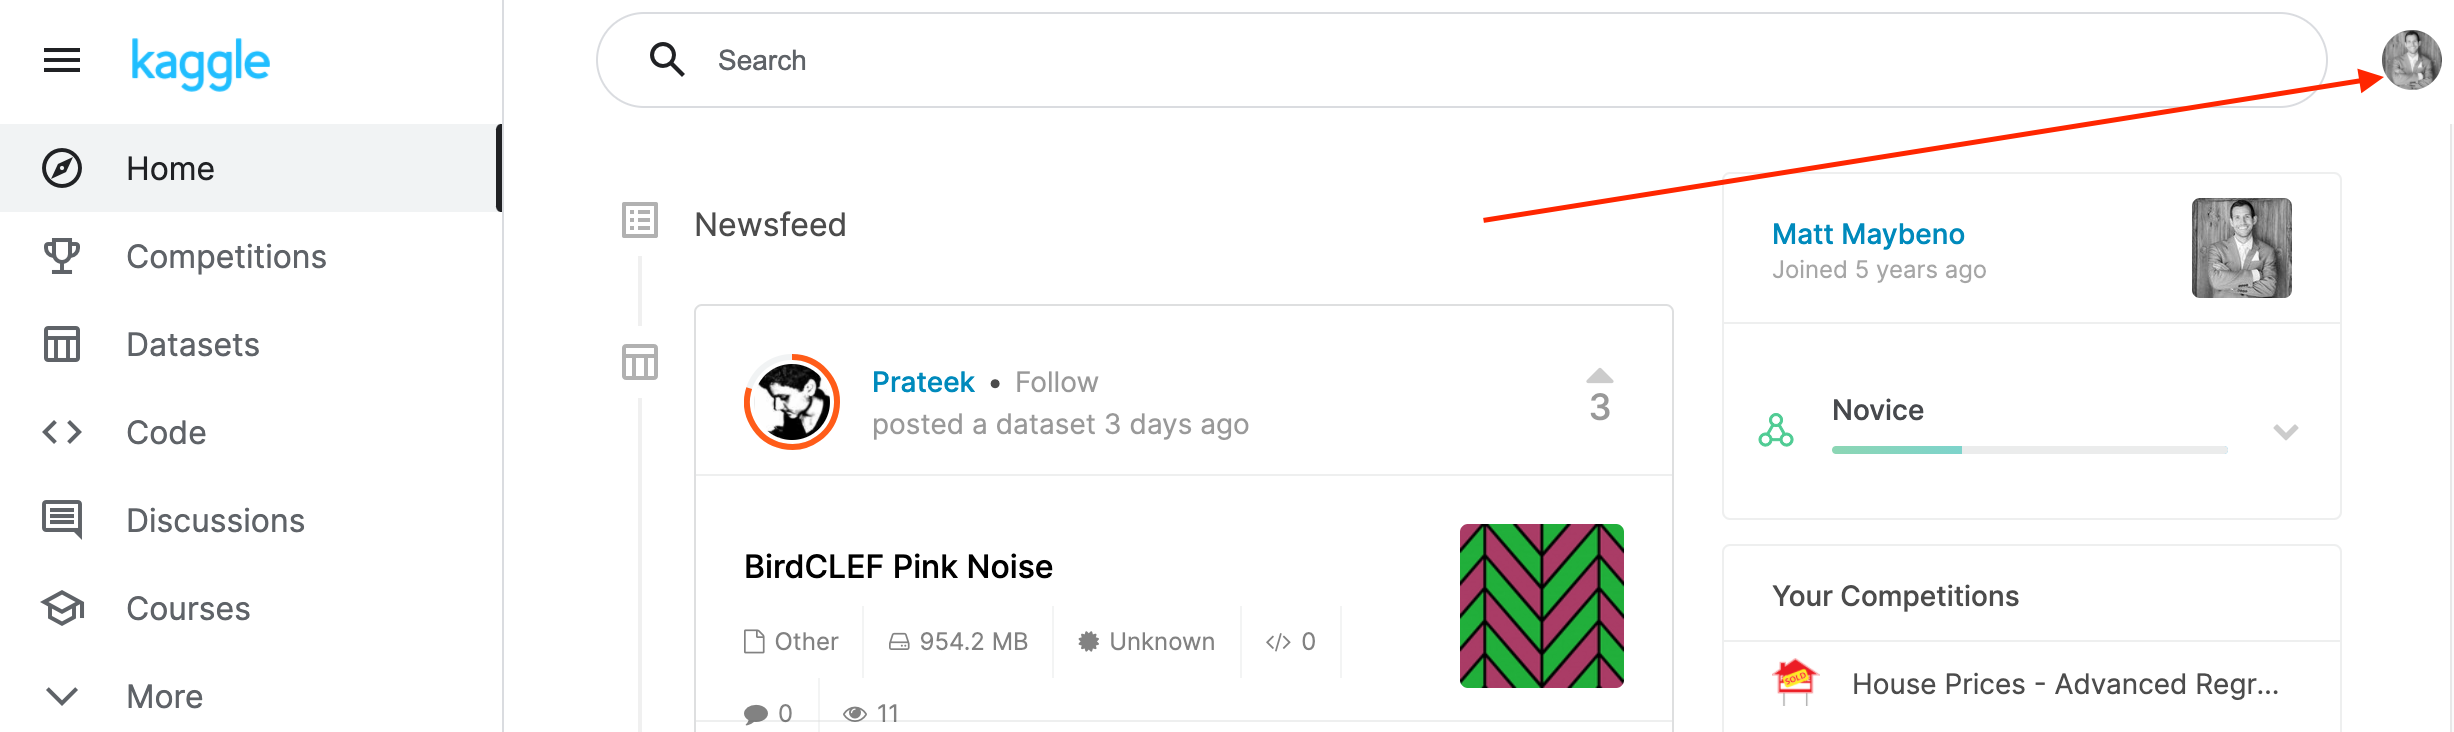
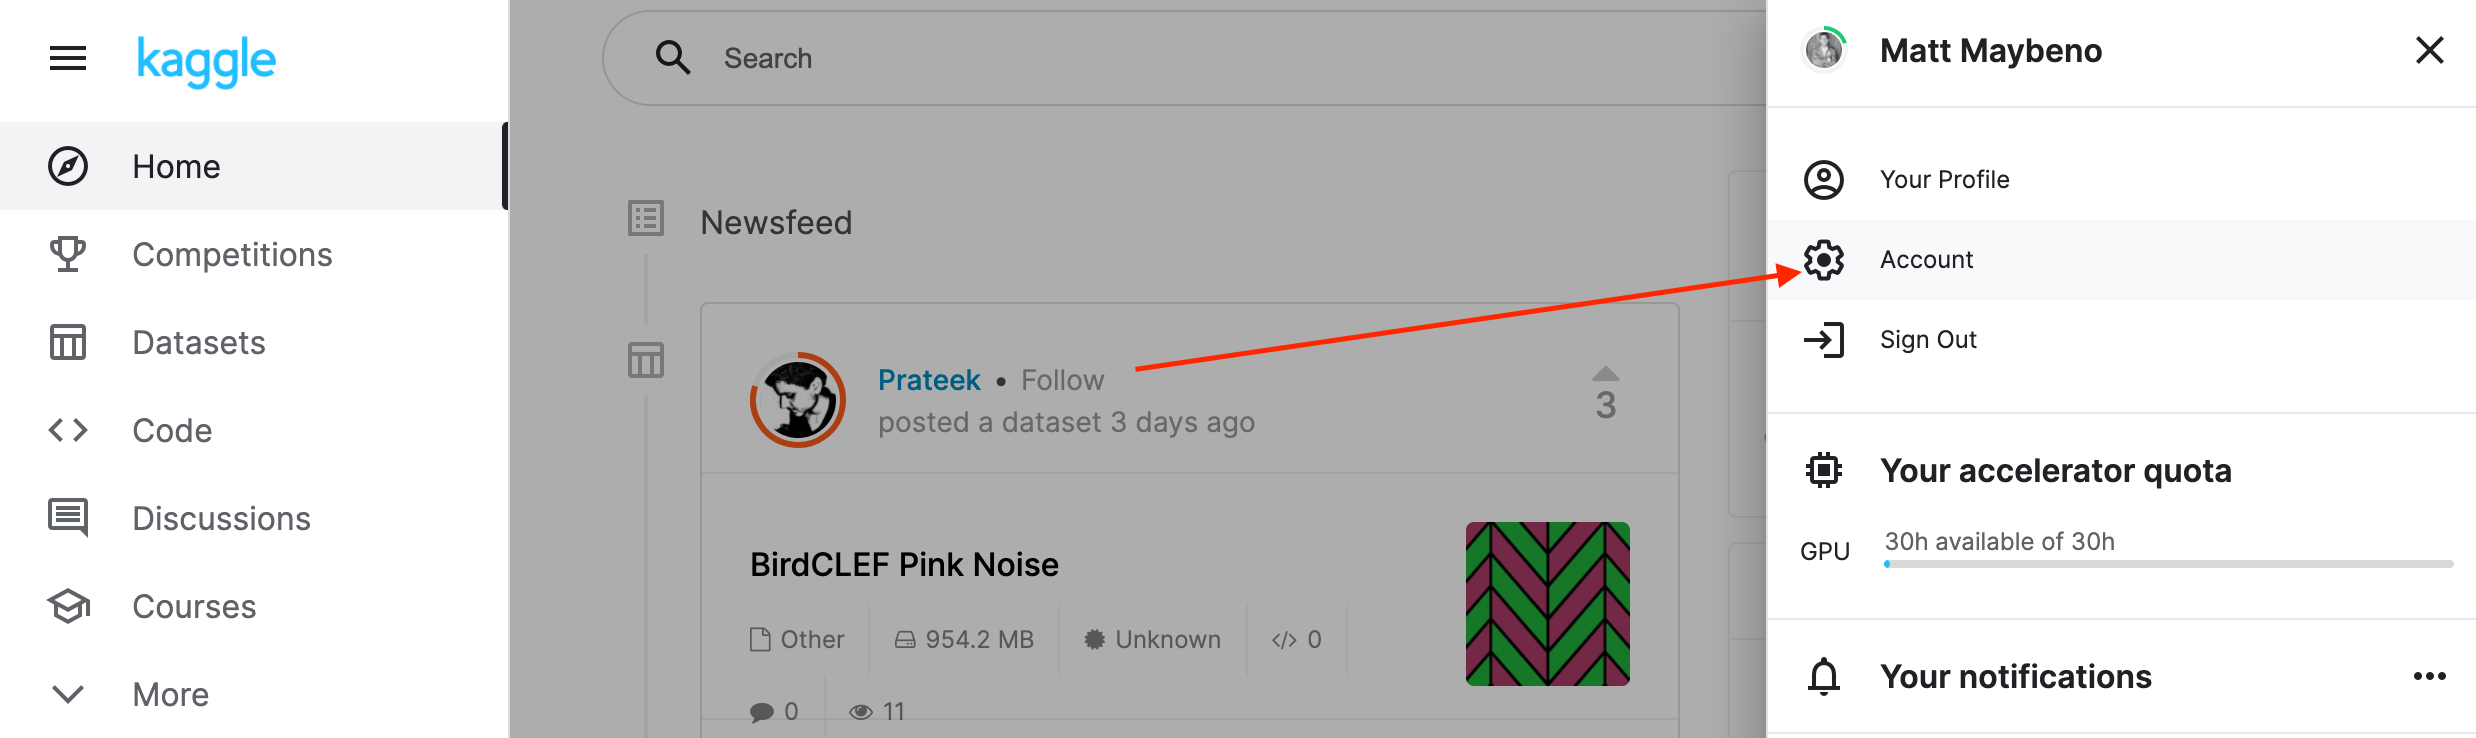
2. Scroll down to API and click Create New API Token.
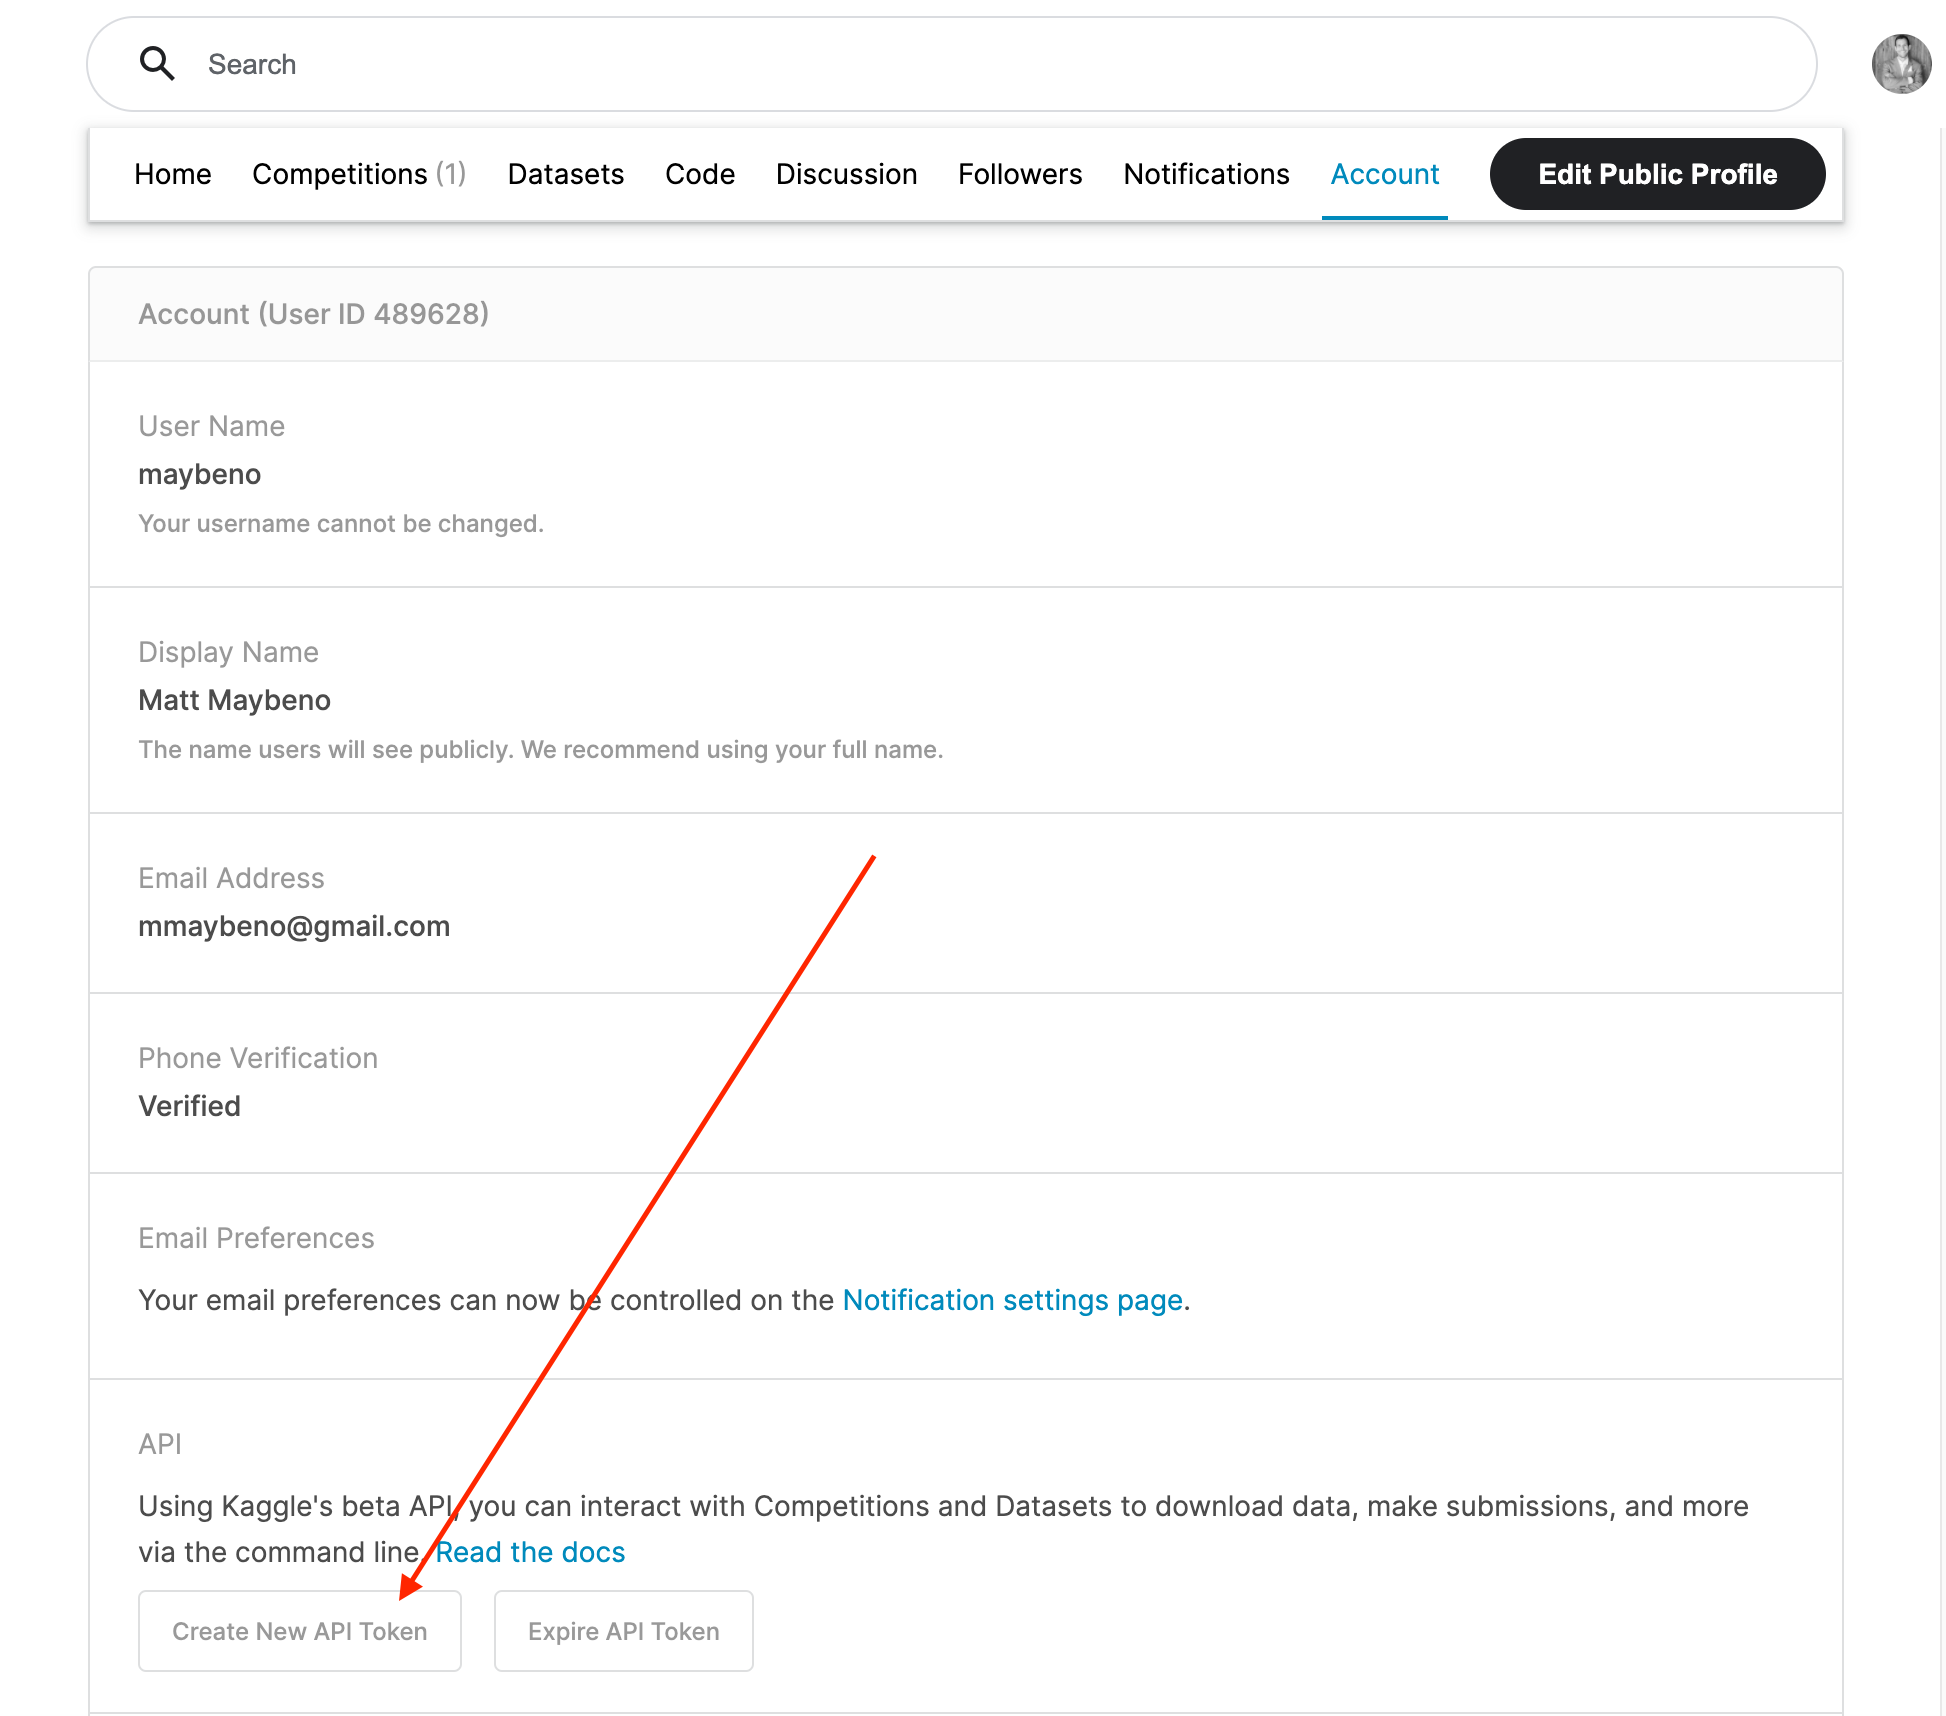
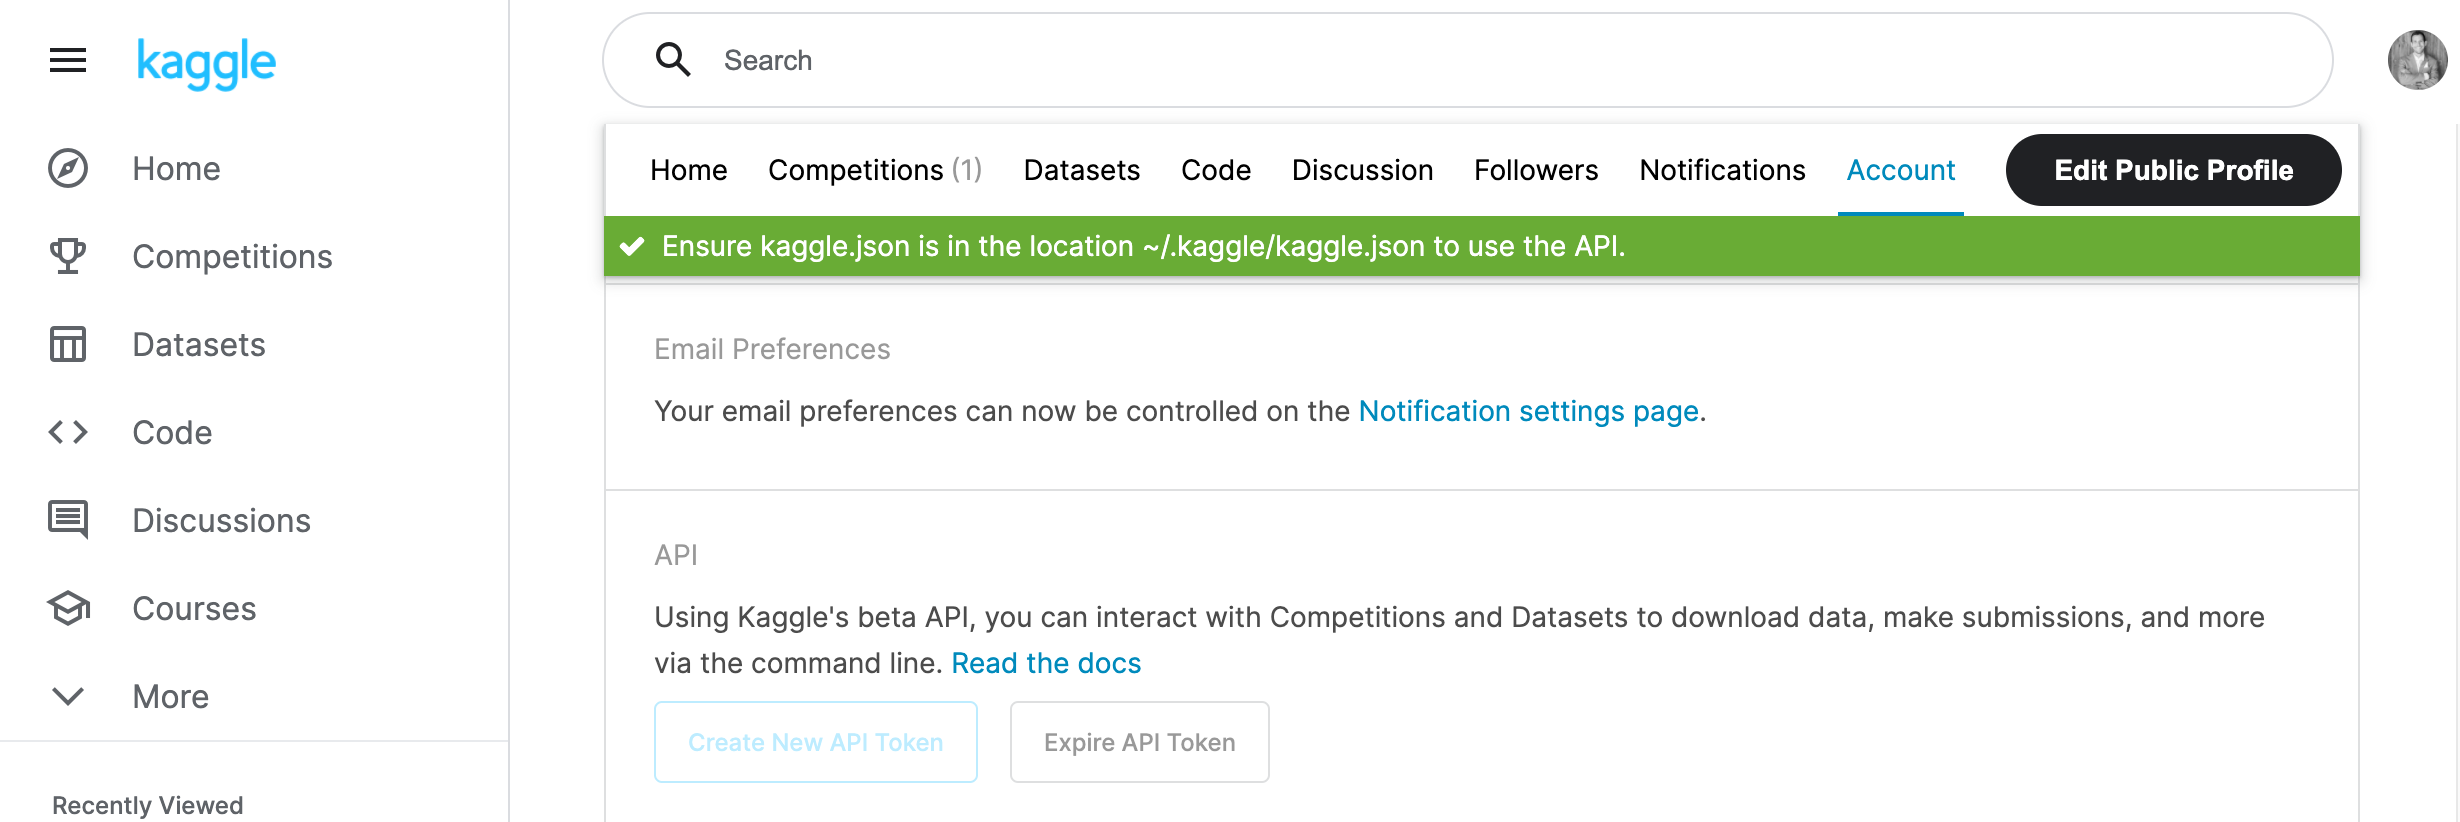
3. Open up `kaggle.json` and use the username and key.
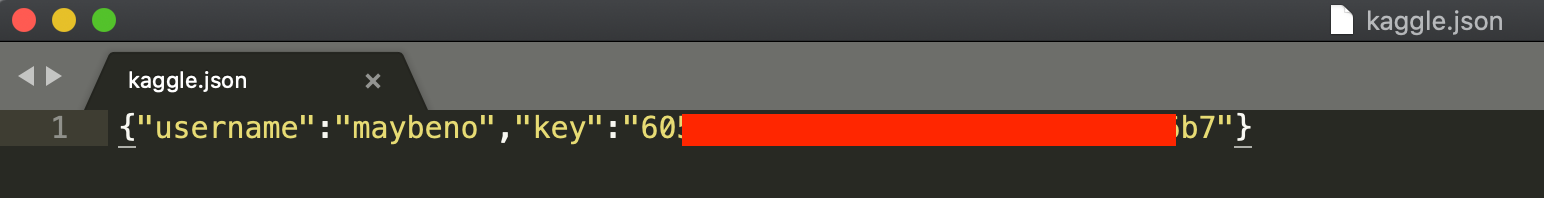

## Step 2: Download the Kaggle dataset using the kaggle python library

### Open up Sagemaker Studio and use starter template

1. Notebook should be using a `ml.t3.medium` instance (2 vCPU + 4 GiB)
2. Notebook should be using kernal: `Python 3 (MXNet 1.8 Python 3.7 CPU Optimized)`

### Install packages

In [2]:
import sagemaker
import boto3
import os

print(sagemaker.__version__)
# !python --version


/opt/conda/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/opt/conda/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml
2.199.0


In [3]:
# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

In [4]:
!pip install -U pip
!pip install -U setuptools wheel
!pip install -U "mxnet<2.0.0" bokeh==2.0.1
!pip install autogluon --no-cache-dir
!pip install python-dotenv
!pip install --upgrade pandas "dask[complete]"

!pip install pandas==2.2.0
# Without --no-cache-dir, smaller aws instances may have trouble installing

  Using cached setuptools-69.0.3-py3-none-any.whl.metadata (6.3 kB)
Using cached setuptools-69.0.3-py3-none-any.whl (819 kB)
  Attempting uninstall: setuptools
    Found existing installation: setuptools 60.2.0
    Uninstalling setuptools-60.2.0:
      Successfully uninstalled setuptools-60.2.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
spyder 5.3.3 requires pyqt5<5.16, which is not installed.
spyder 5.3.3 requires pyqtwebengine<5.16, which is not installed.
autogluon-common 1.0.0 requires pandas<2.2.0,>=2.0.0, but you have pandas 2.2.0 which is incompatible.
autogluon-core 1.0.0 requires pandas<2.2.0,>=2.0.0, but you have pandas 2.2.0 which is incompatible.
autogluon-features 1.0.0 requires pandas<2.2.0,>=2.0.0, but you have pandas 2.2.0 which is incompatible.
autogluon-multimodal 1.0.0 requires pandas<2.2.0,>=2.0.0, but you have pandas 2.2.0 which is inc

In [5]:
!pip install -U ipywidgets
!pip install bokeh==2.0.1


  Using cached bokeh-2.0.1-py3-none-any.whl
  Attempting uninstall: bokeh
    Found existing installation: bokeh 3.3.4
    Uninstalling bokeh-3.3.4:
      Successfully uninstalled bokeh-3.3.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
panel 0.13.1 requires bokeh<2.5.0,>=2.4.0, but you have bokeh 2.0.1 which is incompatible.


In [6]:


from dotenv import load_dotenv
load_dotenv("env.txt")

role = os.getenv('ROLE')
print(role)

arn:aws:iam::477120104741:role/service-role/AmazonSageMaker-ExecutionRole-20240126T115666


### Setup Kaggle API Key

In [7]:
# Install Kaggle API client
!pip install -q Kaggle

In [8]:
# create the .kaggle directory and an empty kaggle.json file
!mkdir -p /root/.kaggle
!touch /root/.kaggle/kaggle.json
!chmod 600 /root/.kaggle/kaggle.json

In [9]:
# Fill in your user name and key from creating the kaggle account and API token file
import json
kaggle_username = os.getenv('KAGGLE_USERNAME')
kaggle_key = os.getenv('KAGGLE_KEY')

# Save API token the kaggle.json file
with open("/root/.kaggle/kaggle.json", "w") as f:
    f.write(json.dumps({"username": kaggle_username, "key": kaggle_key}))

### Download and explore dataset

### Go to the bike sharing demand competition and agree to the terms
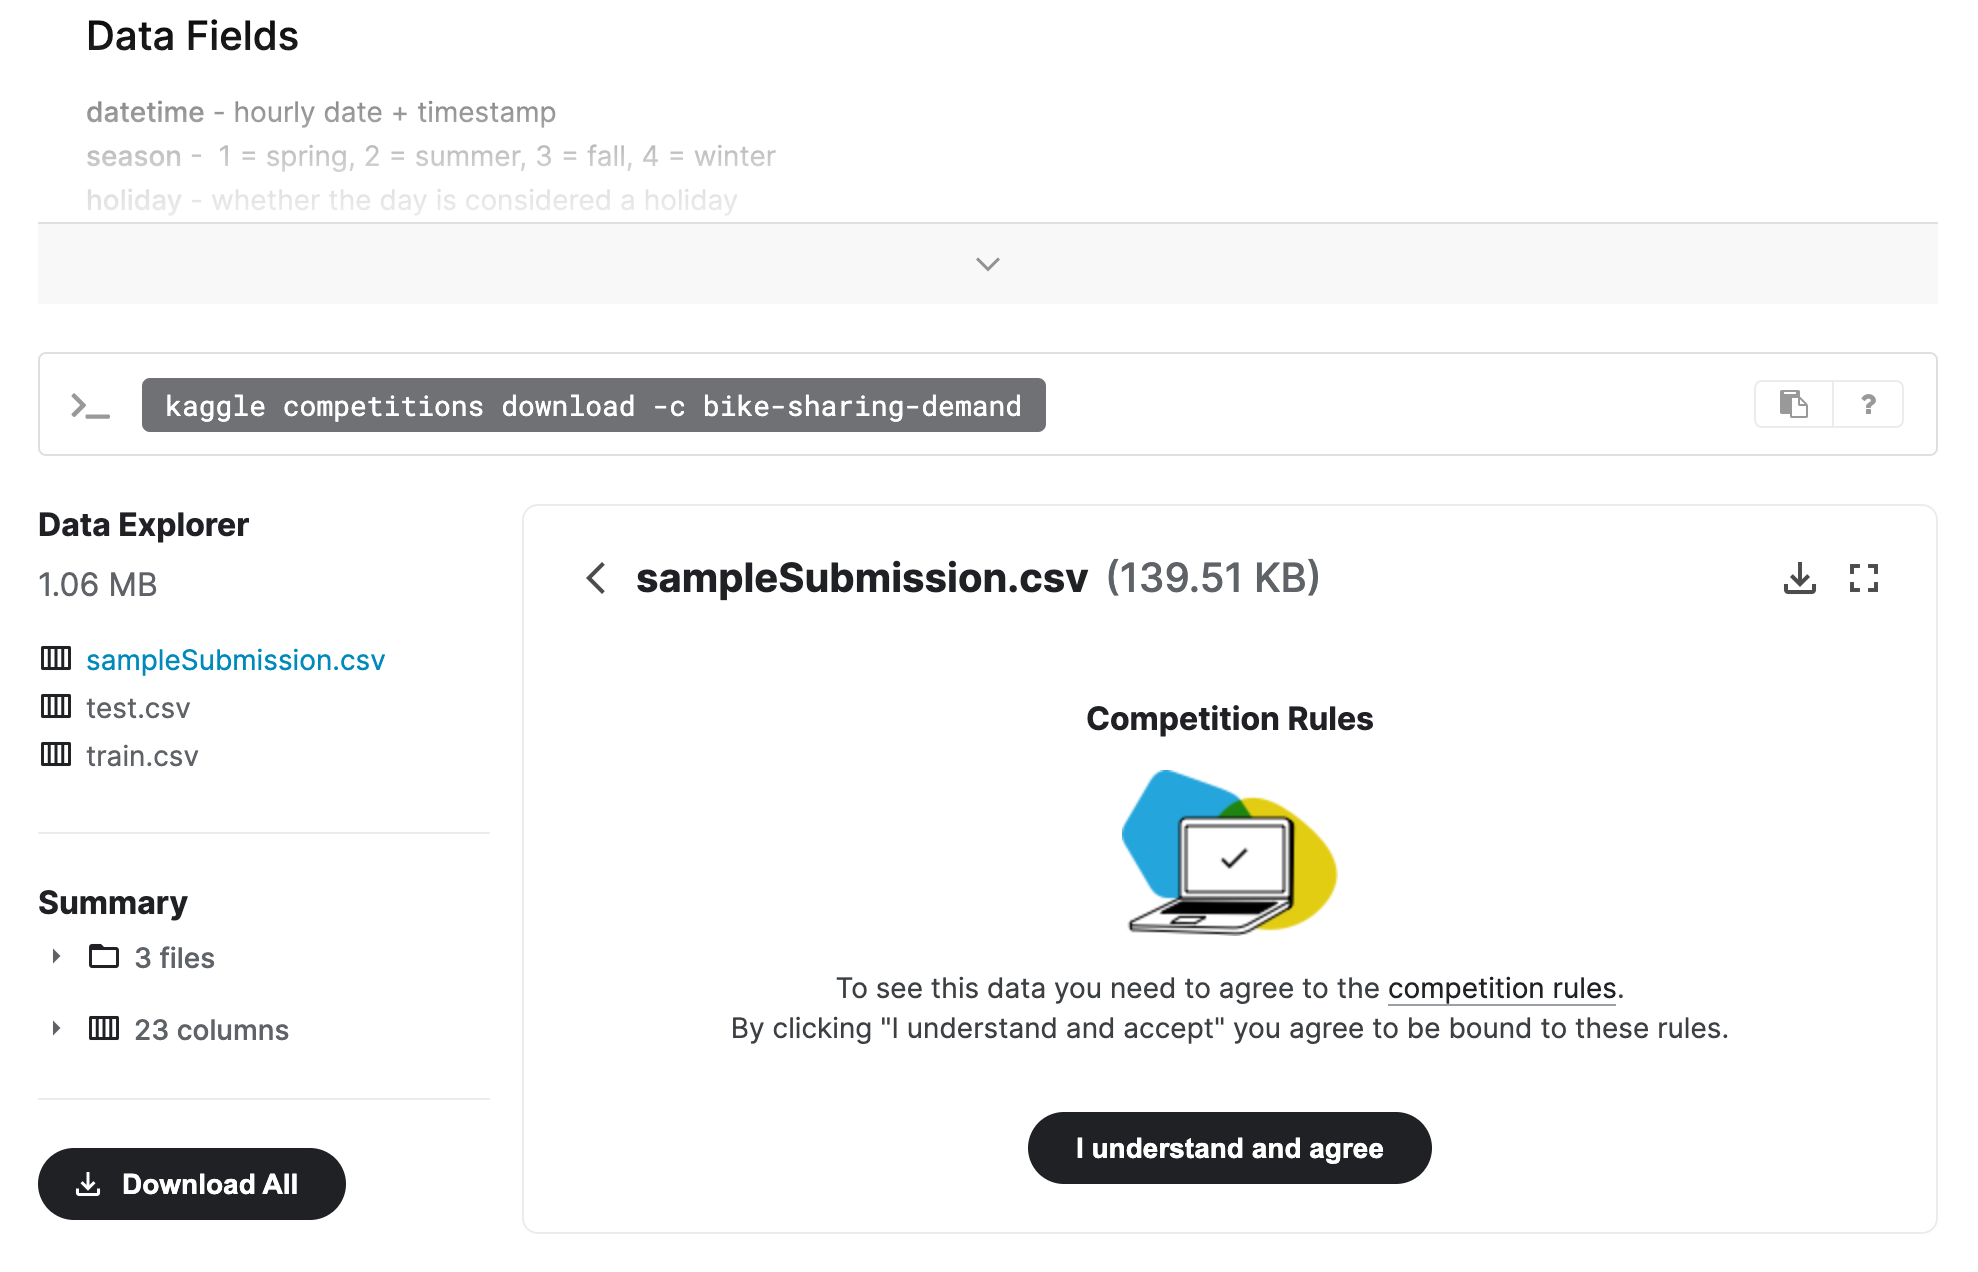

In [10]:
# Download the dataset, it will be in a .zip file so you'll need to unzip it as well.
!kaggle competitions download -c bike-sharing-demand
# If you already downloaded it you can use the -o command to overwrite the file
!unzip -o bike-sharing-demand.zip

bike-sharing-demand.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  bike-sharing-demand.zip
  inflating: sampleSubmission.csv    
  inflating: test.csv                
  inflating: train.csv               


In [11]:
import pandas as pd
from autogluon.tabular import TabularPredictor

In [12]:
# Create the train dataset in pandas by reading the csv
# Set the parsing of the datetime column so you can use some of the `dt` features in pandas later
train = pd.read_csv('train.csv', parse_dates=["datetime"])

# Simple output of the train dataset to view some of the min/max/varition of the dataset features.
train.info()
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [13]:
# Simple output of the train dataset to view some of the min/max/varition of the dataset features.
train.info()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    10886 non-null  datetime64[ns]
 1   season      10886 non-null  int64         
 2   holiday     10886 non-null  int64         
 3   workingday  10886 non-null  int64         
 4   weather     10886 non-null  int64         
 5   temp        10886 non-null  float64       
 6   atemp       10886 non-null  float64       
 7   humidity    10886 non-null  int64         
 8   windspeed   10886 non-null  float64       
 9   casual      10886 non-null  int64         
 10  registered  10886 non-null  int64         
 11  count       10886 non-null  int64         
dtypes: datetime64[ns](1), float64(3), int64(8)
memory usage: 1020.7 KB


Observation. What is type is datetime? Should be datetimelike.

In [14]:
# Check for null values in train data
train.isnull().sum()

datetime      0
season        0
holiday       0
workingday    0
weather       0
temp          0
atemp         0
humidity      0
windspeed     0
casual        0
registered    0
count         0
dtype: int64

In [15]:
# Train dataset summary
train.describe()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
count,10886,10886.000000,10886.000000,10886.000000,10886.000000,10886.00000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000
mean,2011-12-27 05:56:22.399411968,2.506614,0.028569,0.680875,1.418427,20.23086,23.655084,61.886460,12.799395,36.021955,155.552177,191.574132
min,2011-01-01 00:00:00,1.000000,0.000000,0.000000,1.000000,0.82000,0.760000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2011-07-02 07:15:00,2.000000,0.000000,0.000000,1.000000,13.94000,16.665000,47.000000,7.001500,4.000000,36.000000,42.000000
50%,2012-01-01 20:30:00,3.000000,0.000000,1.000000,1.000000,20.50000,24.240000,62.000000,12.998000,17.000000,118.000000,145.000000
75%,2012-07-01 12:45:00,4.000000,0.000000,1.000000,2.000000,26.24000,31.060000,77.000000,16.997900,49.000000,222.000000,284.000000
max,2012-12-19 23:00:00,4.000000,1.000000,1.000000,4.000000,41.00000,45.455000,100.000000,56.996900,367.000000,886.000000,977.000000
std,NaN,1.116174,0.166599,0.466159,0.633839,7.79159,8.474601,19.245033,8.164537,49.960477,151.039033,181.144454


In [16]:
# Create the test pandas dataframe in pandas by reading the csv, remember to parse the datetime!
test = pd.read_csv('test.csv', parse_dates=['datetime'])
test.info()
test.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014


In [17]:
# Same thing as train and test dataset
submission = pd.read_csv('sampleSubmission.csv', parse_dates=['datetime'])
submission.info()
submission.head()

,datetime,count
0,2011-01-20 00:00:00,0
1,2011-01-20 01:00:00,0
2,2011-01-20 02:00:00,0
3,2011-01-20 03:00:00,0
4,2011-01-20 04:00:00,0


In [18]:
print("Columns in Train Dataset:\n", train.columns)
print("\n")
print("Columns in Test Dataset:\n", test.columns)
# fields removed from test dataset
list(set(train.columns).difference(set(test.columns)))

Columns in Train Dataset:
 Index(['datetime', 'season', 'holiday', 'workingday', 'weather', 'temp',
       'atemp', 'humidity', 'windspeed', 'casual', 'registered', 'count'],
      dtype='object')


Columns in Test Dataset:
 Index(['datetime', 'season', 'holiday', 'workingday', 'weather', 'temp',
       'atemp', 'humidity', 'windspeed'],
      dtype='object')


['casual', 'registered', 'count']

## Step 3: Train a model using AutoGluon’s Tabular Prediction

Requirements:
* We are prediting `count`, so it is the label we are setting.
* Ignore `casual` and `registered` columns as they are also not present in the test dataset. 
* Use the `root_mean_squared_error` as the metric to use for evaluation.
* Set a time limit of 10 minutes (600 seconds).
* Use the preset `best_quality` to focus on creating the best model.

In [19]:
predictor = TabularPredictor(
    label="count", problem_type="regression", eval_metric="rmse"
    ).fit(
    train_data=train.drop(['casual', 'registered'], axis=1),
    time_limit=600,
    presets='medium_quality_faster_train')

No path specified. Models will be saved in: "AutogluonModels/ag-20240131_154537"
Preset alias specified: 'medium_quality_faster_train' maps to 'medium_quality'.
Presets specified: ['medium_quality_faster_train']
Beginning AutoGluon training ... Time limit = 600s
AutoGluon will save models to "AutogluonModels/ag-20240131_154537"
=================== System Info ===================
AutoGluon Version:  1.0.0
Python Version:     3.10.6
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP Tue Jan 2 17:47:37 UTC 2024
CPU Count:          2
Memory Avail:       2.77 GB / 3.78 GB (73.3%)
Disk Space Avail:   8589934573.63 GB / 8589934592.00 GB (100.0%)
Train Data Rows:    10886
Train Data Columns: 9
Label Column:       count
Problem Type:       regression
Preprocessing data ...
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    2835.64 MB
	Train Data (Original)  Memory Usage: 0.75 MB (0.0% o

[1000]	valid_set's rmse: 136.065


	-135.958	 = Validation score   (-root_mean_squared_error)
	4.65s	 = Training   runtime
	0.11s	 = Validation runtime
Fitting model: LightGBM ... Training model for up to 591.89s of the 591.89s of remaining time.
	-134.0804	 = Validation score   (-root_mean_squared_error)
	2.25s	 = Training   runtime
	0.05s	 = Validation runtime
Fitting model: RandomForestMSE ... Training model for up to 589.35s of the 589.34s of remaining time.
	-122.0128	 = Validation score   (-root_mean_squared_error)
	13.79s	 = Training   runtime
	0.15s	 = Validation runtime
Fitting model: CatBoost ... Training model for up to 572.84s of the 572.84s of remaining time.
	-134.2362	 = Validation score   (-root_mean_squared_error)
	14.65s	 = Training   runtime
	0.02s	 = Validation runtime
Fitting model: ExtraTreesMSE ... Training model for up to 558.06s of the 558.05s of remaining time.
	-128.4294	 = Validation score   (-root_mean_squared_error)
	6.46s	 = Training   runtime
	0.19s	 = Validation runtime
Fitting model: Ne

### Review AutoGluon's training run with ranking of models that did the best.

In [20]:
predictor.fit_summary()

*** Summary of fit() ***
Estimated performance of each model:
                  model   score_val              eval_metric  pred_time_val   fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0        KNeighborsDist  -92.442085  root_mean_squared_error       0.015865   0.024898                0.015865           0.024898            1       True          2
1   WeightedEnsemble_L2  -92.442085  root_mean_squared_error       0.016537   0.600051                0.000673           0.575153            2       True         12
2        KNeighborsUnif -109.739422  root_mean_squared_error       0.017735   2.539670                0.017735           2.539670            1       True          1
3       RandomForestMSE -122.012844  root_mean_squared_error       0.146535  13.789391                0.146535          13.789391            1       True          5
4         ExtraTreesMSE -128.429416  root_mean_squared_error       0.190322   6.464246                0.190322   

{'model_types': {'KNeighborsUnif': 'KNNModel',
  'KNeighborsDist': 'KNNModel',
  'LightGBMXT': 'LGBModel',
  'LightGBM': 'LGBModel',
  'RandomForestMSE': 'RFModel',
  'CatBoost': 'CatBoostModel',
  'ExtraTreesMSE': 'XTModel',
  'NeuralNetFastAI': 'NNFastAiTabularModel',
  'XGBoost': 'XGBoostModel',
  'NeuralNetTorch': 'TabularNeuralNetTorchModel',
  'LightGBMLarge': 'LGBModel',
  'WeightedEnsemble_L2': 'WeightedEnsembleModel'},
 'model_performance': {'KNeighborsUnif': -109.73942190555698,
  'KNeighborsDist': -92.44208479870365,
  'LightGBMXT': -135.95803375936984,
  'LightGBM': -134.0804268849742,
  'RandomForestMSE': -122.01284447953923,
  'CatBoost': -134.23616330181272,
  'ExtraTreesMSE': -128.42941608551303,
  'NeuralNetFastAI': -136.51325517168812,
  'XGBoost': -135.7689524728067,
  'NeuralNetTorch': -140.02270087878156,
  'LightGBMLarge': -132.1735605846617,
  'WeightedEnsemble_L2': -92.44208479870365},
 'model_best': 'WeightedEnsemble_L2',
 'model_paths': {'KNeighborsUnif': ['KN

In [21]:
# Display leaderboard dataframe to see which model has the highest score
leaderboard_df = pd.DataFrame(predictor.leaderboard(silent=True))
leaderboard_df

,model,score_val,eval_metric,pred_time_val,fit_time,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,KNeighborsDist,-92.442085,root_mean_squared_error,0.015865,0.024898,0.015865,0.024898,1,True,2
1,WeightedEnsemble_L2,-92.442085,root_mean_squared_error,0.016537,0.600051,0.000673,0.575153,2,True,12
2,KNeighborsUnif,-109.739422,root_mean_squared_error,0.017735,2.539670,0.017735,2.539670,1,True,1
3,RandomForestMSE,-122.012844,root_mean_squared_error,0.146535,13.789391,0.146535,13.789391,1,True,5
4,ExtraTreesMSE,-128.429416,root_mean_squared_error,0.190322,6.464246,0.190322,6.464246,1,True,7
5,LightGBMLarge,-132.173561,root_mean_squared_error,0.024659,2.323575,0.024659,2.323575,1,True,11
6,LightGBM,-134.080427,root_mean_squared_error,0.048009,2.251470,0.048009,2.251470,1,True,4
7,CatBoost,-134.236163,root_mean_squared_error,0.016520,14.654339,0.016520,14.654339,1,True,6
8,XGBoost,-135.768952,root_mean_squared_error,0.030055,1.440866,0.030055,1.440866,1,True,9
9,LightGBMXT,-135.958034,root_mean_squared_error,0.114386,4.652089,0.114386,4.652089,1,True,3


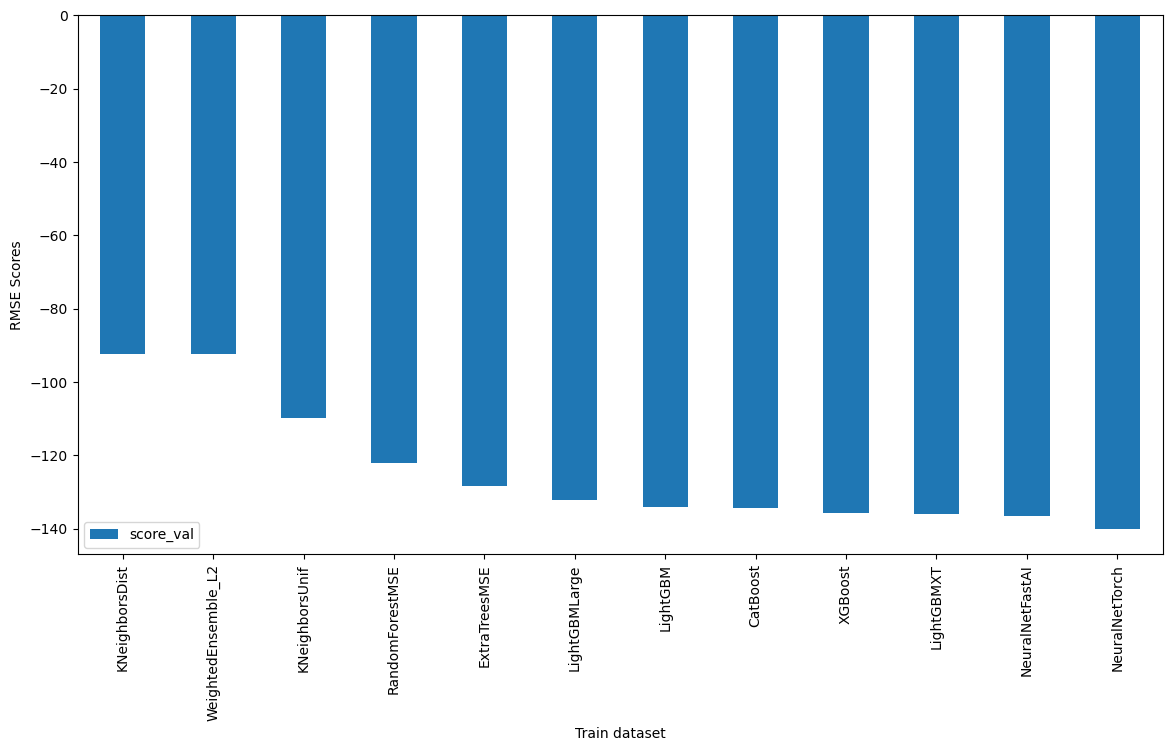

In [22]:
# Output the model's `score_val` in a bar chart to compare performance
import matplotlib.pyplot as plt
leaderboard_df.plot(kind="bar", x="model", y="score_val", figsize=(14, 7))
plt.ylabel("RMSE Scores")
plt.xlabel("Train dataset")
plt.show()

### Create predictions from test dataset

In [23]:
predictions = predictor.predict(test, as_pandas=True)
predictions.head()

0    51.861626
1    56.686295
2    59.077763
3    60.468830
4    61.419930
Name: count, dtype: float32

#### NOTE: Kaggle will reject the submission if we don't set everything to be > 0.

In [24]:
# Describe the `predictions` series to see if there are any negative values
predictions.describe()

count    6493.000000
mean      135.819412
std       132.525269
min         3.424214
25%        23.827692
50%        71.032265
75%       203.938919
max       537.853882
Name: count, dtype: float64

In [25]:
# How many negative values do we have?
(predictions < 0).sum()
predictions[predictions<0].sum()

negative_pred_count = predictions.apply(lambda x: 1 if x < 0 else 0)
print("Total negative prediction values :", (negative_pred_count==1).sum())

Total negative prediction values : 0


In [26]:
# Set them to zero.Twice.
predictions[predictions < 0] = 0
predictions.lt(0).sum().sum()

0

In [27]:
# How many negative values do we have?
(predictions < 0).sum()

0

### Set predictions to submission dataframe, save, and submit

In [28]:
submission["count"] = predictions
#submission['count'] = submission['count'].apply(lambda x: round(x))
submission.to_csv("submission.csv", index=False)

In [29]:
!kaggle competitions submit -c bike-sharing-demand -f submission.csv -m "first raw submission"

100%|█████████████████████████████████████████| 188k/188k [00:00<00:00, 367kB/s]
Successfully submitted to Bike Sharing Demand

#### View submission via the command line or in the web browser under the competition's page - `My Submissions`

In [30]:
!kaggle competitions submissions -c bike-sharing-demand | tail -n +1 | head -n 6

fileName                     date                 description                               status    publicScore  privateScore  
---------------------------  -------------------  ----------------------------------------  --------  -----------  ------------  
submission.csv               2024-01-31 15:47:45  first raw submission                      complete  1.86412      1.86412       
submission_new_hpo1.csv      2024-01-30 15:56:30  hpo1: new features with hyperparameters1  complete  0.53574      0.53574       
submission_new_hpo.csv       2024-01-30 15:56:00  hpo: new features with hyperparameters    complete  0.53682      0.53682       
submission_new_features.csv  2024-01-30 15:55:48  new features                              complete  0.51653      0.51653       


#### Initial score of 1.86378

## Step 4: Exploratory Data Analysis and Creating an additional feature
* Any additional feature will do, but a great suggestion would be to separate out the datetime into hour, day, or month parts.

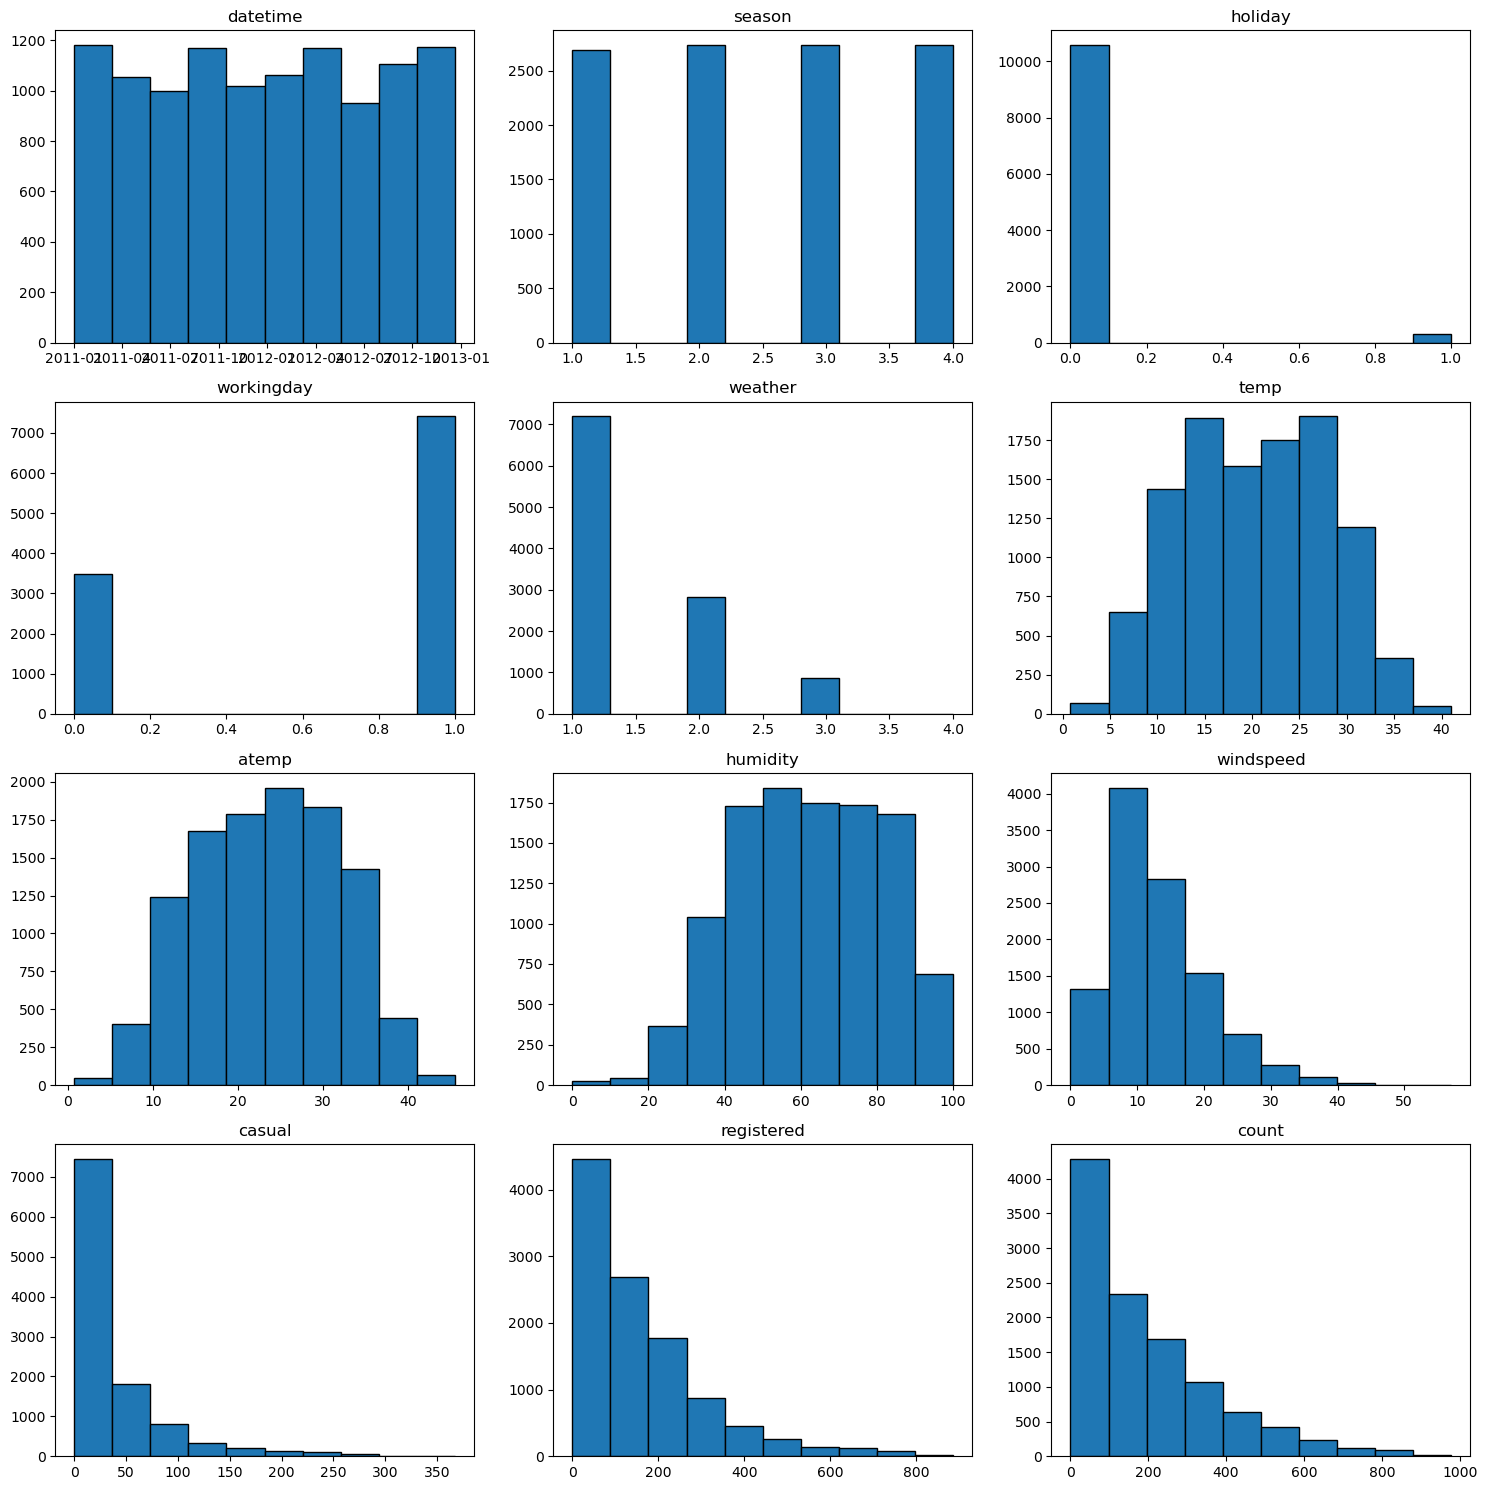

In [31]:
# Create a histogram of all features to show the distribution of each one relative to the data. This is part of the exploritory data analysis
train.hist(edgecolor='k', grid=False, figsize=(15,15))
plt.tight_layout()
plt.show()

<AxesSubplot:xlabel='datetime'>

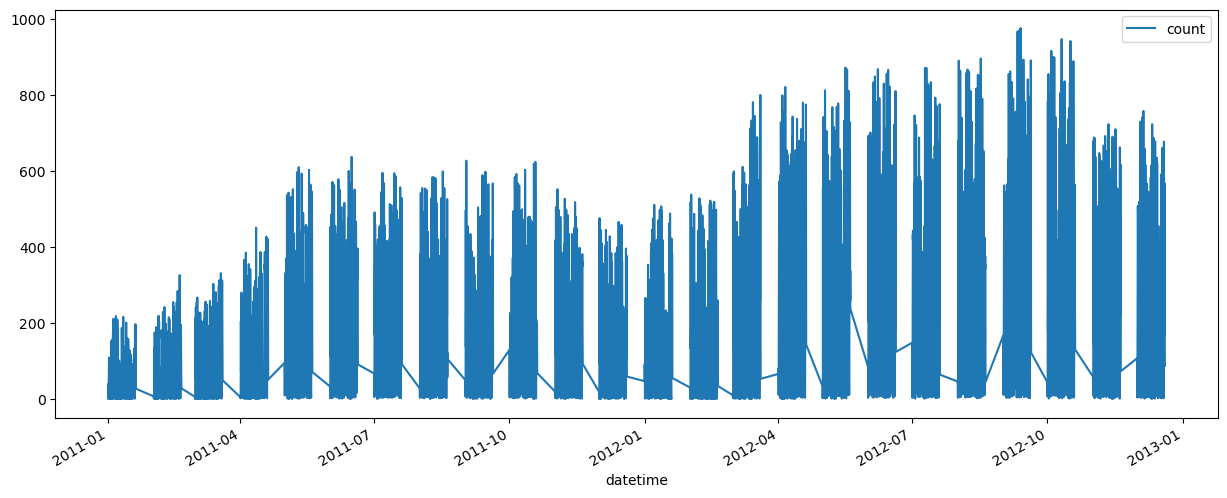

In [32]:
# time series plot for demand
train.plot(x='datetime', y='count', figsize=(15, 6))

Create New Features


In [33]:
train['datetime'].head()

0   2011-01-01 00:00:00
1   2011-01-01 01:00:00
2   2011-01-01 02:00:00
3   2011-01-01 03:00:00
4   2011-01-01 04:00:00
Name: datetime, dtype: datetime64[ns]

We observe that data points occur hourly. So 'datetime' feature is split into year, month, day, hour.

In [34]:
# create a new feature by splitting the 'datetime' feature in train data
train['year'] = train['datetime'].dt.year
train['hour'] = train['datetime'].dt.hour
train['day'] = train['datetime'].dt.day
train['month'] = train['datetime'].dt.month
# day or dayofweek?
train['day'] = train['datetime'].dt.dayofweek

train.drop(["datetime"], axis=1, inplace=True)     # Drop 'datetime' feature
train.head()


,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,hour,day,month
0,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011,0,5,1
1,1,0,0,1,9.02,13.635,80,0.0,8,32,40,2011,1,5,1
2,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2011,2,5,1
3,1,0,0,1,9.84,14.395,75,0.0,3,10,13,2011,3,5,1
4,1,0,0,1,9.84,14.395,75,0.0,0,1,1,2011,4,5,1


In [35]:
test['year'] = test['datetime'].dt.year
test['month'] = test['datetime'].dt.month
test['day'] = test['datetime'].dt.dayofweek
test['hour'] = test['datetime'].dt.hour

test.drop(["datetime"], axis=1, inplace=True)   # Drop 'datetime' feature
test.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,year,month,day,hour
0,1,0,1,1,10.66,11.365,56,26.0027,2011,1,3,0
1,1,0,1,1,10.66,13.635,56,0.0000,2011,1,3,1
2,1,0,1,1,10.66,13.635,56,0.0000,2011,1,3,2
3,1,0,1,1,10.66,12.880,56,11.0014,2011,1,3,3
4,1,0,1,1,10.66,12.880,56,11.0014,2011,1,3,4


<Figure size 800x640 with 0 Axes>

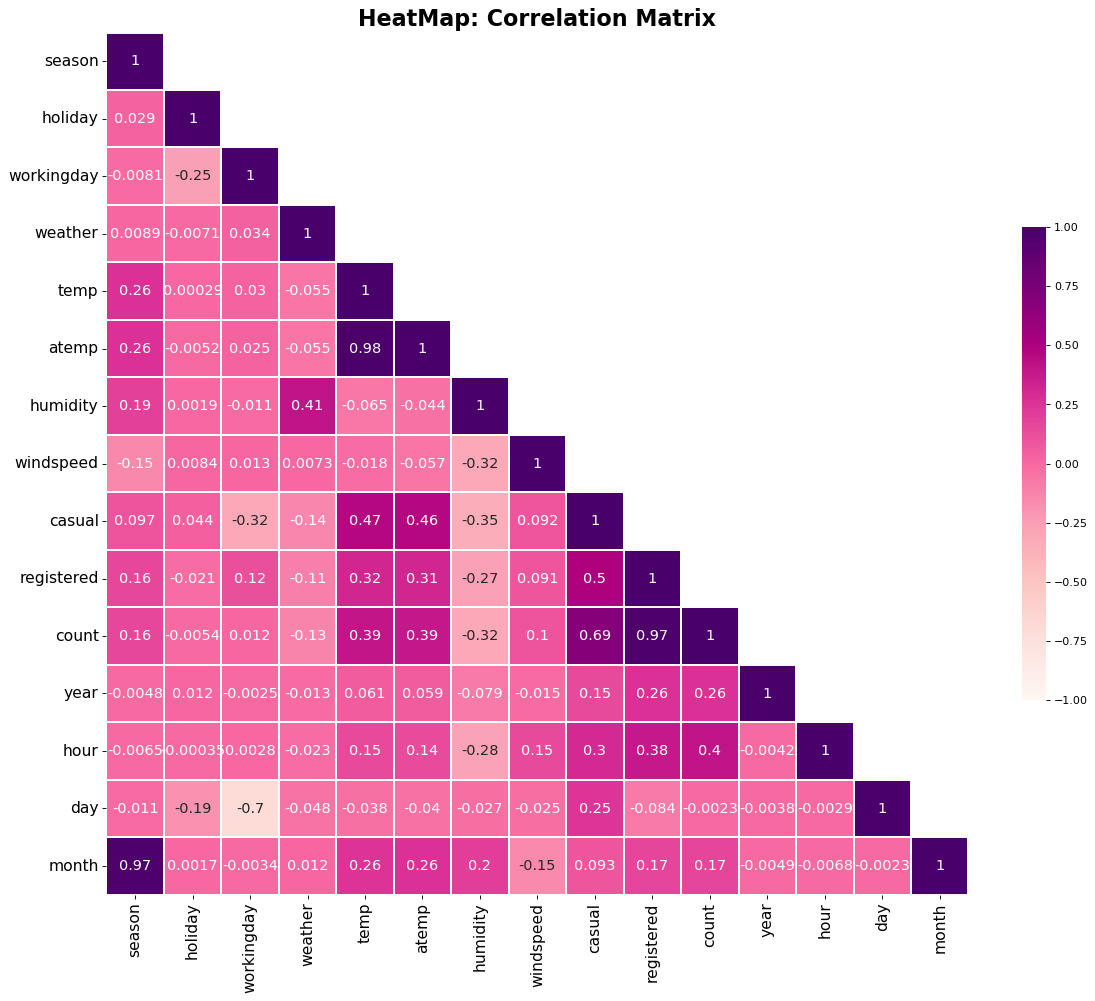

In [36]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
plt.figure(figsize=(10, 8), dpi=80)
corr_data = train.copy()

corr_matrix = corr_data.corr()
plt.subplots(figsize=(15, 13), dpi=80)

# Remove redundant correlations
corr_mask = np.array(corr_matrix)
corr_mask[np.tril_indices_from(corr_mask)] = False

# sn.heatmap(train.drop(['count', 'registered','casual'], axis=1).corr(), annot=True)
sns.heatmap(corr_matrix, cmap= 'RdPu', cbar_kws={"shrink": .5}, vmin=-1, vmax=1, center=0,
            square=True, mask=corr_mask, annot=True, linewidths=0.01, annot_kws={"size":13})
plt.xticks(fontsize=14, rotation=90)
plt.yticks(fontsize=14, rotation=0)
plt.title("HeatMap: Correlation Matrix", fontsize=20, fontweight='bold')
plt.tight_layout()
plt.autoscale()
plt.show()

## Make category types for these so models know they are not just numbers
* AutoGluon originally sees these as ints, but in reality they are int representations of a category.
* Setting the dtype to category will classify these as categories in AutoGluon.

In [37]:
# verify feature data types
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   season      10886 non-null  int64  
 1   holiday     10886 non-null  int64  
 2   workingday  10886 non-null  int64  
 3   weather     10886 non-null  int64  
 4   temp        10886 non-null  float64
 5   atemp       10886 non-null  float64
 6   humidity    10886 non-null  int64  
 7   windspeed   10886 non-null  float64
 8   casual      10886 non-null  int64  
 9   registered  10886 non-null  int64  
 10  count       10886 non-null  int64  
 11  year        10886 non-null  int32  
 12  hour        10886 non-null  int32  
 13  day         10886 non-null  int32  
 14  month       10886 non-null  int32  
dtypes: float64(3), int32(4), int64(8)
memory usage: 1.1 MB


In [38]:
train["season"] = train.season.astype('category')
train["weather"] = train.weather.astype('category')
test["season"] = test.season.astype('category')
test["weather"] = test.weather.astype('category')

In [39]:
# View new feature
train.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,hour,day,month
0,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011,0,5,1
1,1,0,0,1,9.02,13.635,80,0.0,8,32,40,2011,1,5,1
2,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2011,2,5,1
3,1,0,0,1,9.84,14.395,75,0.0,3,10,13,2011,3,5,1
4,1,0,0,1,9.84,14.395,75,0.0,0,1,1,2011,4,5,1


In [40]:
# Verify data types
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   season      10886 non-null  category
 1   holiday     10886 non-null  int64   
 2   workingday  10886 non-null  int64   
 3   weather     10886 non-null  category
 4   temp        10886 non-null  float64 
 5   atemp       10886 non-null  float64 
 6   humidity    10886 non-null  int64   
 7   windspeed   10886 non-null  float64 
 8   casual      10886 non-null  int64   
 9   registered  10886 non-null  int64   
 10  count       10886 non-null  int64   
 11  year        10886 non-null  int32   
 12  hour        10886 non-null  int32   
 13  day         10886 non-null  int32   
 14  month       10886 non-null  int32   
dtypes: category(2), float64(3), int32(4), int64(6)
memory usage: 957.3 KB


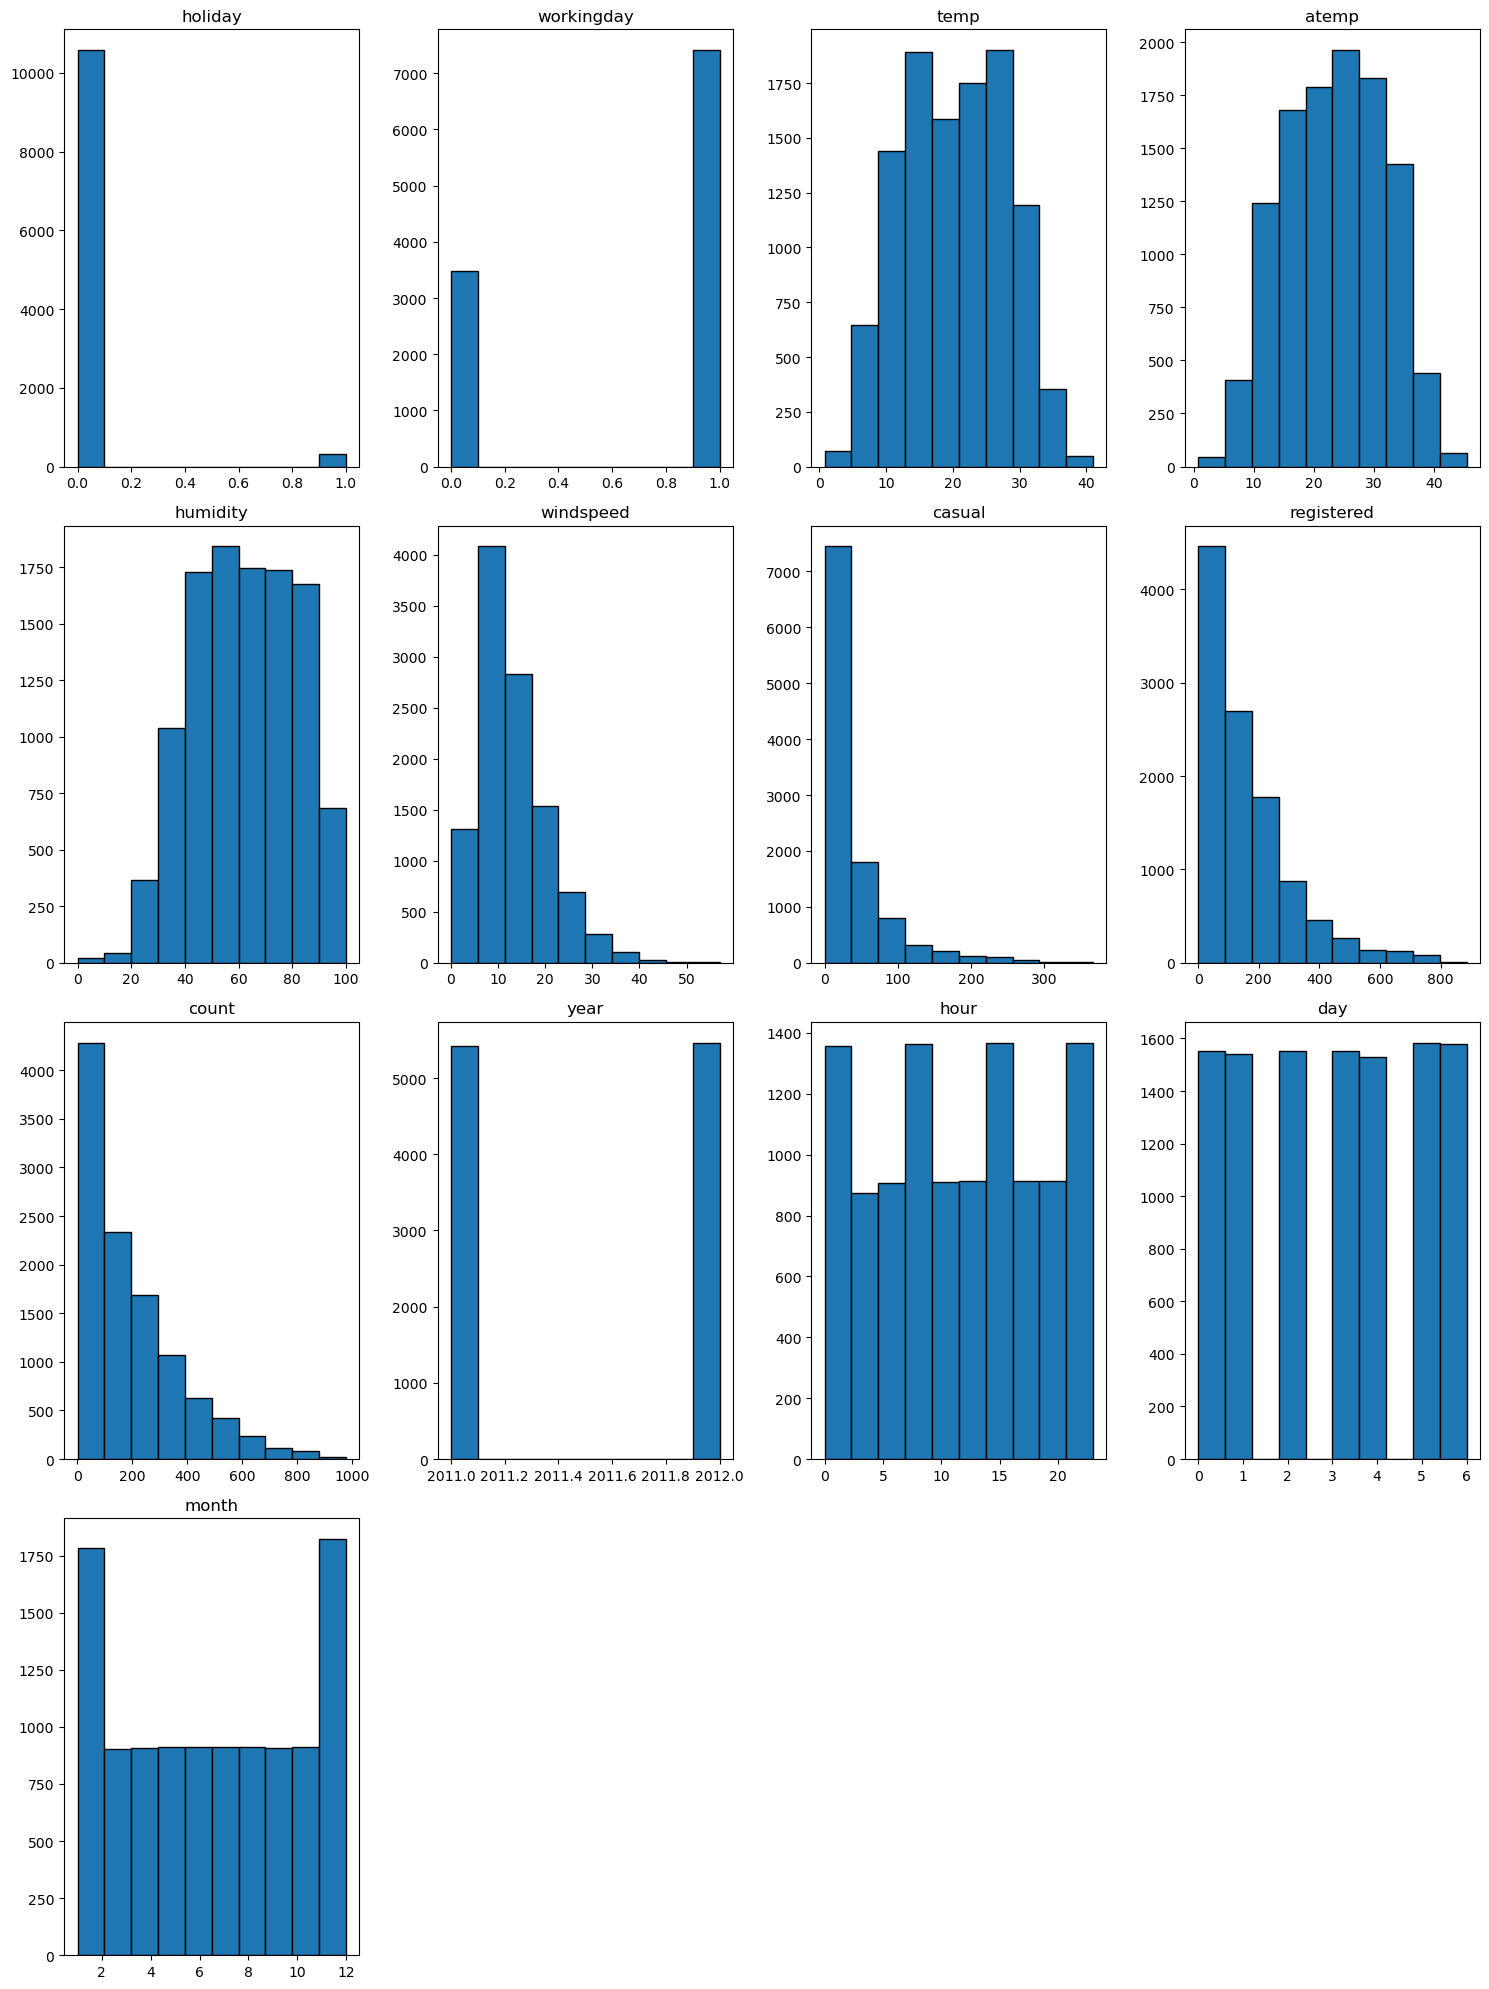

In [41]:
# View histogram of all features again now with the hour feature
train.hist(edgecolor='k', grid=False, figsize=(15,20))
plt.tight_layout()
plt.show()

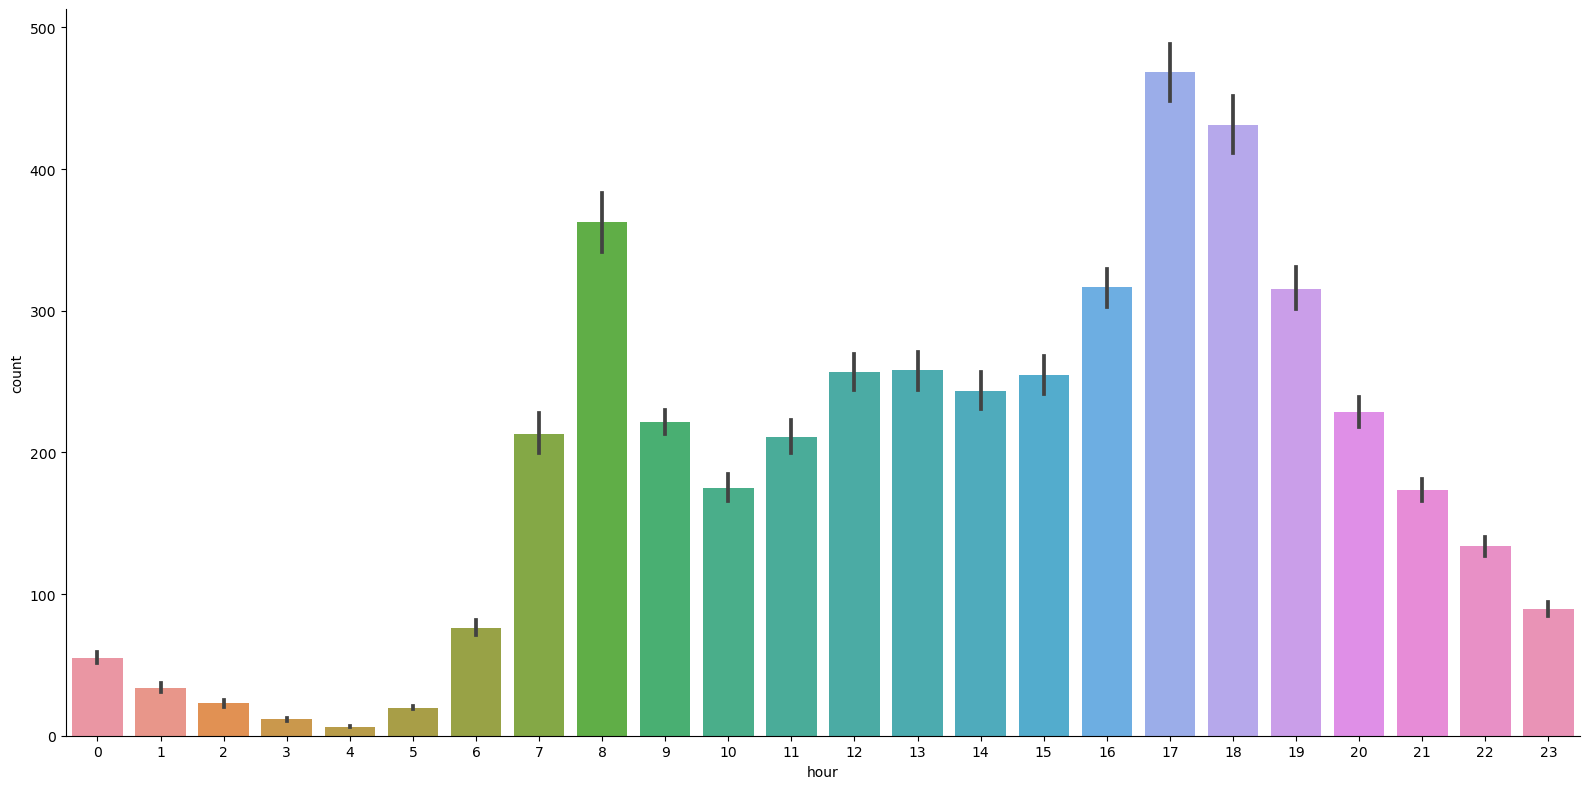

In [42]:
# Graphically display variation in count by hour
import seaborn as sns
sns.catplot(x="hour", y="count", data=train, kind='bar', height=8, aspect=2) 
plt.tight_layout()
plt.show()

Observations

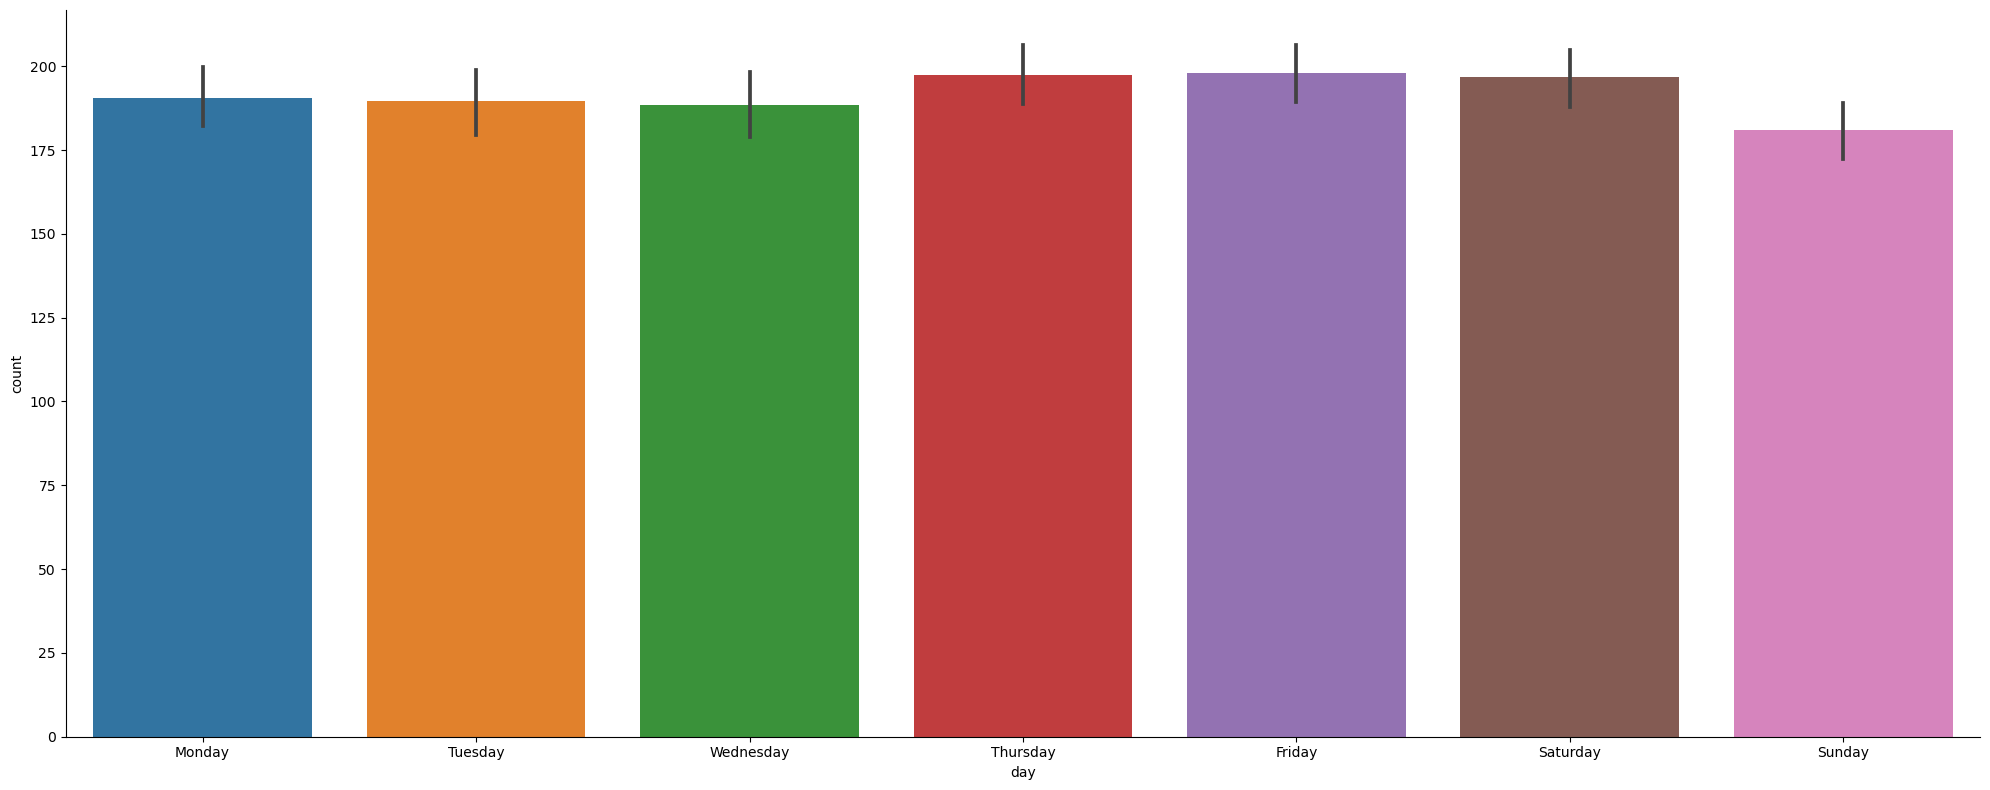

In [43]:
# Graphically display variation in count by day
sns.catplot(x="day", y="count", data=train, kind='bar', height=8, aspect=2.5) 
plt.xticks(ticks=range(0,7), labels=["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"])
plt.tight_layout()
plt.show()

Observations

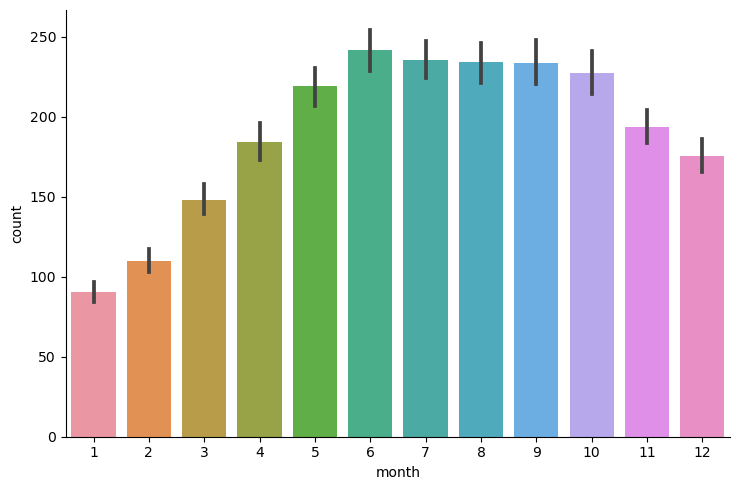

In [44]:
# Graphically display variation in count by month
sns.catplot(x="month", y="count", data=train, kind='bar' ,height=5, aspect=1.5) 

plt.tight_layout()
plt.show()

Observations

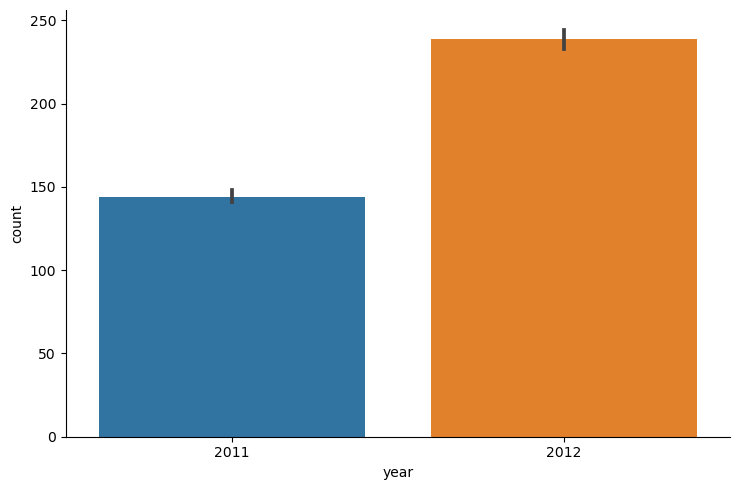

In [45]:
# Graphically display variation in count by month

sns.catplot(x="year", y="count", data=train, kind='bar', height=5, aspect=1.5)

plt.tight_layout()
plt.show()

Observations

## Step 5: Rerun the model with the same settings as before, just with more features

In [46]:
#from autogluon.tabular import TabularPredictor

In [47]:

predictor_new_features = TabularPredictor(
    label="count", problem_type="regression", eval_metric="rmse"
    ).fit(
    train_data=train.drop(['casual', 'registered'], axis=1),
    time_limit=600,
    presets='medium_quality_faster_train')



No path specified. Models will be saved in: "AutogluonModels/ag-20240131_154800"
Preset alias specified: 'medium_quality_faster_train' maps to 'medium_quality'.
Presets specified: ['medium_quality_faster_train']
Beginning AutoGluon training ... Time limit = 600s
AutoGluon will save models to "AutogluonModels/ag-20240131_154800"
=================== System Info ===================
AutoGluon Version:  1.0.0
Python Version:     3.10.6
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP Tue Jan 2 17:47:37 UTC 2024
CPU Count:          2
Memory Avail:       2.03 GB / 3.78 GB (53.6%)
Disk Space Avail:   8589934573.63 GB / 8589934592.00 GB (100.0%)
Train Data Rows:    10886
Train Data Columns: 12
Label Column:       count
Problem Type:       regression
Preprocessing data ...
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    2075.02 MB
	Train Data (Original)  Memory Usage: 0.69 MB (0.0% 

[1000]	valid_set's rmse: 39.4861
[2000]	valid_set's rmse: 38.4593
[3000]	valid_set's rmse: 38.2677
[4000]	valid_set's rmse: 38.1789
[5000]	valid_set's rmse: 38.1067
[6000]	valid_set's rmse: 38.1581
[7000]	valid_set's rmse: 38.1964


	-38.0803	 = Validation score   (-root_mean_squared_error)
	16.86s	 = Training   runtime
	1.96s	 = Validation runtime
Fitting model: LightGBM ... Training model for up to 578.72s of the 578.71s of remaining time.


[1000]	valid_set's rmse: 38.51


	-38.4086	 = Validation score   (-root_mean_squared_error)
	2.6s	 = Training   runtime
	0.1s	 = Validation runtime
Fitting model: RandomForestMSE ... Training model for up to 575.69s of the 575.68s of remaining time.
	-40.4381	 = Validation score   (-root_mean_squared_error)
	11.36s	 = Training   runtime
	0.15s	 = Validation runtime
Fitting model: CatBoost ... Training model for up to 561.76s of the 561.75s of remaining time.
	-36.9049	 = Validation score   (-root_mean_squared_error)
	300.93s	 = Training   runtime
	0.03s	 = Validation runtime
Fitting model: ExtraTreesMSE ... Training model for up to 260.54s of the 260.53s of remaining time.
	-40.6472	 = Validation score   (-root_mean_squared_error)
	7.62s	 = Training   runtime
	0.14s	 = Validation runtime
Fitting model: NeuralNetFastAI ... Training model for up to 250.35s of the 250.34s of remaining time.
	-45.7873	 = Validation score   (-root_mean_squared_error)
	17.95s	 = Training   runtime
	0.04s	 = Validation runtime
Fitting model:

In [48]:
predictor_new_features.fit_summary()

*** Summary of fit() ***
Estimated performance of each model:
                  model   score_val              eval_metric  pred_time_val    fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0   WeightedEnsemble_L2  -34.933550  root_mean_squared_error       2.236800  434.316404                0.000499           0.488992            2       True         12
1              CatBoost  -36.904926  root_mean_squared_error       0.028429  300.930542                0.028429         300.930542            1       True          6
2         LightGBMLarge  -37.335023  root_mean_squared_error       0.086478    3.939425                0.086478           3.939425            1       True         11
3            LightGBMXT  -38.080302  root_mean_squared_error       1.960010   16.855116                1.960010          16.855116            1       True          3
4              LightGBM  -38.408550  root_mean_squared_error       0.104091    2.599001                0.104

{'model_types': {'KNeighborsUnif': 'KNNModel',
  'KNeighborsDist': 'KNNModel',
  'LightGBMXT': 'LGBModel',
  'LightGBM': 'LGBModel',
  'RandomForestMSE': 'RFModel',
  'CatBoost': 'CatBoostModel',
  'ExtraTreesMSE': 'XTModel',
  'NeuralNetFastAI': 'NNFastAiTabularModel',
  'XGBoost': 'XGBoostModel',
  'NeuralNetTorch': 'TabularNeuralNetTorchModel',
  'LightGBMLarge': 'LGBModel',
  'WeightedEnsemble_L2': 'WeightedEnsembleModel'},
 'model_performance': {'KNeighborsUnif': -119.76724001886542,
  'KNeighborsDist': -116.97138254464915,
  'LightGBMXT': -38.08030176073657,
  'LightGBM': -38.40855028370911,
  'RandomForestMSE': -40.43808569096157,
  'CatBoost': -36.90492565703845,
  'ExtraTreesMSE': -40.64718519072485,
  'NeuralNetFastAI': -45.78727360117691,
  'XGBoost': -38.765752376457435,
  'NeuralNetTorch': -39.527013160580495,
  'LightGBMLarge': -37.33502346710779,
  'WeightedEnsemble_L2': -34.93355038081525},
 'model_best': 'WeightedEnsemble_L2',
 'model_paths': {'KNeighborsUnif': ['KNeig

In [49]:
# Leaderboard dataframe
leaderboard_new_features_df = pd.DataFrame(predictor_new_features.leaderboard(silent=True))
leaderboard_new_features_df

,model,score_val,eval_metric,pred_time_val,fit_time,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,WeightedEnsemble_L2,-34.933550,root_mean_squared_error,2.236800,434.316404,0.000499,0.488992,2,True,12
1,CatBoost,-36.904926,root_mean_squared_error,0.028429,300.930542,0.028429,300.930542,1,True,6
2,LightGBMLarge,-37.335023,root_mean_squared_error,0.086478,3.939425,0.086478,3.939425,1,True,11
3,LightGBMXT,-38.080302,root_mean_squared_error,1.960010,16.855116,1.960010,16.855116,1,True,3
4,LightGBM,-38.408550,root_mean_squared_error,0.104091,2.599001,0.104091,2.599001,1,True,4
5,XGBoost,-38.765752,root_mean_squared_error,0.052514,2.805837,0.052514,2.805837,1,True,9
6,NeuralNetTorch,-39.527013,root_mean_squared_error,0.012581,100.743857,0.012581,100.743857,1,True,10
7,RandomForestMSE,-40.438086,root_mean_squared_error,0.148804,11.358471,0.148804,11.358471,1,True,5
8,ExtraTreesMSE,-40.647185,root_mean_squared_error,0.138058,7.620307,0.138058,7.620307,1,True,7
9,NeuralNetFastAI,-45.787274,root_mean_squared_error,0.044765,17.945068,0.044765,17.945068,1,True,8


In [50]:
# Get predictions
predictor_new_features = predictor_new_features.predict(test)

In [51]:
(predictor_new_features < 0).sum()

57

In [52]:
# Remember to set all negative values to zero
predictor_new_features = predictor_new_features.clip(lower=0)

In [53]:
(predictor_new_features < 0).sum()

0

In [ ]:
submission_new_features = pd.read_csv('submission.csv', parse_dates=['datetime'])
# Simple output of the train dataset to view some of the min/max/varition of the dataset features.
submission_new_features.info()

In [54]:

# Same submitting predictions
submission_new_features["count"] = predictor_new_features
submission_new_features['count'] = submission_new_features['count'].apply(lambda x: round(x))
submission_new_features.to_csv("submission_new_features.csv", index=False)

In [55]:
!kaggle competitions submit -c bike-sharing-demand -f submission_new_features.csv -m "new features"

100%|█████████████████████████████████████████| 149k/149k [00:00<00:00, 309kB/s]
Successfully submitted to Bike Sharing Demand

In [56]:
!kaggle competitions submissions -c bike-sharing-demand | tail -n +1 | head -n 6

fileName                     date                 description                               status    publicScore  privateScore  
---------------------------  -------------------  ----------------------------------------  --------  -----------  ------------  
submission_new_features.csv  2024-01-31 15:56:12  new features                              complete  0.51653      0.51653       
submission.csv               2024-01-31 15:47:45  first raw submission                      complete  1.86412      1.86412       
submission_new_hpo1.csv      2024-01-30 15:56:30  hpo1: new features with hyperparameters1  complete  0.53574      0.53574       
submission_new_hpo.csv       2024-01-30 15:56:00  hpo: new features with hyperparameters    complete  0.53682      0.53682       


#### New Score of 0.51653

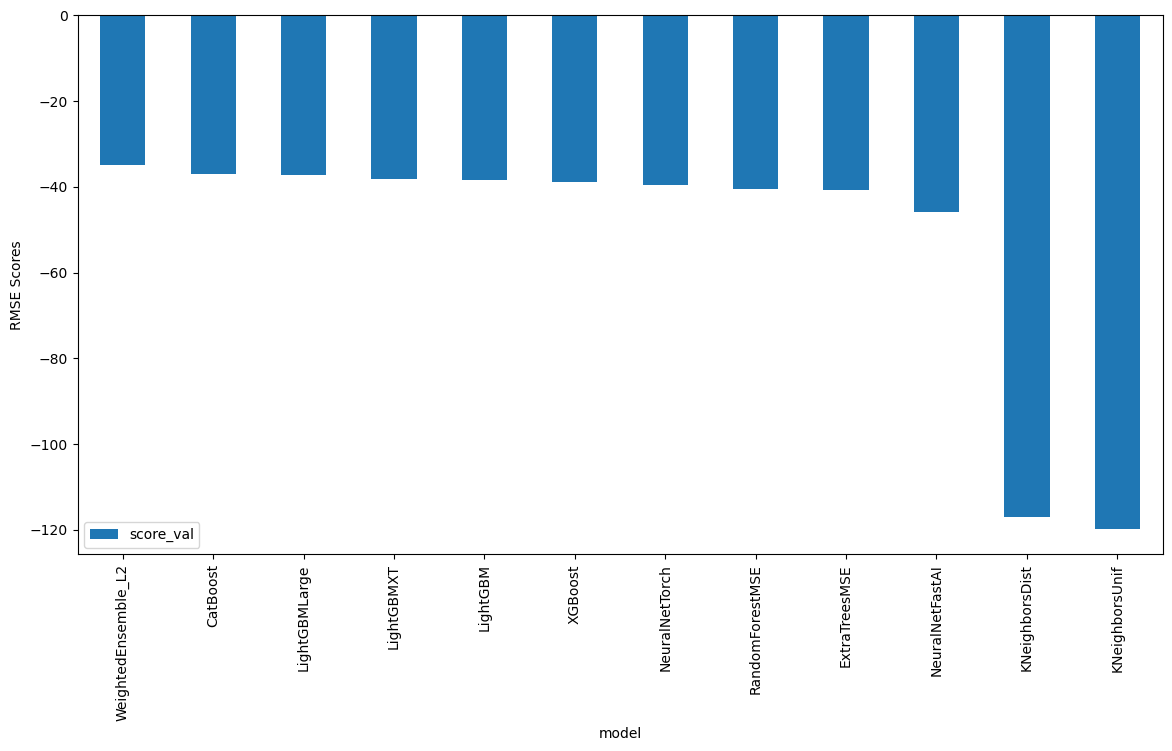

In [57]:
import matplotlib.pyplot as plt
leaderboard_new_features_df.plot(kind="bar", x="model", y="score_val", figsize=(14, 7))
plt.ylabel("RMSE Scores")
plt.show()

## Step 6: Hyper parameter optimization
* There are many options for hyper parameter optimization.
* Options are to change the AutoGluon higher level parameters or the individual model hyperparameters.
* The hyperparameters of the models themselves that are in AutoGluon. Those need the `hyperparameter` and `hyperparameter_tune_kwargs` arguments.

In [58]:
# !pip install -q ipywidgets==7.4.2
# !jupyter nbextension enable --py --sys-prefix widgetsnbextension

In [59]:
import autogluon.core as ag
from autogluon.tabular.configs.hyperparameter_configs import get_hyperparameter_config
import autogluon.common as ag_common
hyperparameters = get_hyperparameter_config('multimodal') #taking hyperparameter configs
hyperparameters

{'NN_TORCH': {},
 'GBM': [{},
  {'extra_trees': True, 'ag_args': {'name_suffix': 'XT'}},
  'GBMLarge'],
 'CAT': {},
 'XGB': {},
 'AG_AUTOMM': {},
 'VW': {}}

In [60]:


nn_options = {
    'num_epochs': 10,
    'learning_rate': ag_common.space.Real(1e-4, 1e-2, default=5e-4, log=True),
    'activation': ag_common.space.Categorical('relu', 'softrelu', 'tanh'),
    'layers': ag_common.space.Categorical([100],[1000],[200,100],[300,200,100]),
    'dropout_prob': ag_common.space.Real(0.0, 0.5, default=0.1),
    'batch_size': ag_common.space.Categorical(16, 32, 64)
}
 
gbm_options = {
    'num_boost_round': 100,
    'num_leaves': ag_common.space.Int(lower=26, upper=66, default=36),
    'learning_rate': ag_common.space.Real(0.01, 0.2, default=0.1, log=True),
    'min_data_in_leaf': ag_common.space.Int(lower=10, upper=100, default=20),
}
 
rf_options = {
    'n_estimators': ag_common.space.Int(lower=100, upper=1000, default=200),
    'max_depth': ag_common.space.Int(lower=5, upper=20, default=10),
    'min_samples_leaf': ag_common.space.Int(lower=1, upper=10, default=1),
    'max_features': ag_common.space.Categorical('sqrt', 'log2')
}

xgb_options = {
    'n_estimators': ag_common.space.Int(lower=100, upper=1000, default=200),
    'max_depth': ag_common.space.Int(lower=5, upper=20, default=10),
    'learning_rate': ag_common.space.Real(0.01, 0.2, default=0.1, log=True),
    'min_child_weight': ag_common.space.Real(1, 10, default=1),
    'subsample': ag_common.space.Real(0.5, 1, default=1),
    'colsample_bytree': ag_common.space.Real(0.5, 1, default=1)
}

# hyperparameters = {
#     'GBM': gbm_options,
#     'NN': nn_options,
#     'RF': rf_options,
#     'XGB': xgb_options
# } 
 
hyperparameter_tune_kwargs = { 
    'scheduler': 'local',
    'searcher': 'bayesopt',# 'auto'
    'num_trials': 50,
    'time_limits':1200
}
 

In [61]:
predictor_new_hpo = TabularPredictor(
    label="count", 
    verbosity=0,
    eval_metric='root_mean_squared_error', 
    learner_kwargs={"ignored_columns": ["casual", "registered"]}
).fit(
    train_data=train,
    time_limit=600, 
    presets="medium_quality_faster_train", #"optimize_for_deployment" 
    hyperparameters=hyperparameters,
    hyperparameter_tune_kwargs=hyperparameter_tune_kwargs
)

Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/autogluon/core/trainer/abstract_trainer.py", line 2150, in _train_single_full
    hpo_models, hpo_results = model.hyperparameter_tune(
  File "/opt/conda/lib/python3.10/site-packages/autogluon/core/models/abstract/abstract_model.py", line 1473, in hyperparameter_tune
    return self._hyperparameter_tune(hpo_executor=hpo_executor, **kwargs)
  File "/opt/conda/lib/python3.10/site-packages/autogluon/core/models/abstract/abstract_model.py", line 1532, in _hyperparameter_tune
    hpo_executor.execute(
  File "/opt/conda/lib/python3.10/site-packages/autogluon/core/hpo/executors.py", line 525, in execute
    scheduler = scheduler_cls(model_trial, search_space=self.search_space, train_fn_kwargs=train_fn_kwargs, **scheduler_params)
  File "/opt/conda/lib/python3.10/site-packages/autogluon/core/scheduler/seq_scheduler.py", line 97, in __init__
    self.searcher: LocalSearcher = self.get_searcher_(searcher, train_f

In [62]:
#predictor_new_hpo.leaderboard(silent=True).plot(kind="bar", x="model", y="score_val")

In [63]:
leaderboard_new_hpo_df = pd.DataFrame(predictor_new_hpo.leaderboard(silent=True))
leaderboard_new_hpo_df

,model,score_val,eval_metric,pred_time_val,fit_time,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,LightGBMLarge,-38.747398,root_mean_squared_error,0.277466,5.062830,0.277466,5.062830,1,True,1
1,WeightedEnsemble_L2,-38.747398,root_mean_squared_error,0.277971,5.068647,0.000506,0.005816,2,True,2


In [64]:
predictor_new_hpo.fit_summary(verbosity=3)

*** Summary of fit() ***
Estimated performance of each model:
                 model  score_val              eval_metric  pred_time_val  fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0        LightGBMLarge -38.747398  root_mean_squared_error       0.277466  5.062830                0.277466           5.062830            1       True          1
1  WeightedEnsemble_L2 -38.747398  root_mean_squared_error       0.277971  5.068647                0.000506           0.005816            2       True          2
Number of models trained: 2
Types of models trained:
{'WeightedEnsembleModel', 'LGBModel'}
Bagging used: False 
Multi-layer stack-ensembling used: False 
Feature Metadata (Processed):
(raw dtype, special dtypes):
('category', [])  : 2 | ['season', 'weather']
('float', [])     : 3 | ['temp', 'atemp', 'windspeed']
('int', [])       : 4 | ['humidity', 'hour', 'day', 'month']
('int', ['bool']) : 3 | ['holiday', 'workingday', 'year']
*** End of fit() su

{'model_types': {'LightGBMLarge': 'LGBModel',
  'WeightedEnsemble_L2': 'WeightedEnsembleModel'},
 'model_performance': {'LightGBMLarge': -38.747398151768635,
  'WeightedEnsemble_L2': -38.747398151768635},
 'model_best': 'WeightedEnsemble_L2',
 'model_paths': {'LightGBMLarge': ['LightGBMLarge'],
  'WeightedEnsemble_L2': ['WeightedEnsemble_L2']},
 'model_fit_times': {'LightGBMLarge': 5.062830448150635,
  'WeightedEnsemble_L2': 0.005816221237182617},
 'model_pred_times': {'LightGBMLarge': 0.2774655818939209,
  'WeightedEnsemble_L2': 0.0005056858062744141},
 'num_bag_folds': 0,
 'max_stack_level': 2,
 'model_hyperparams': {'LightGBMLarge': {'learning_rate': 0.03,
   'num_leaves': 128,
   'feature_fraction': 0.9,
   'min_data_in_leaf': 5},
  'WeightedEnsemble_L2': {'use_orig_features': False,
   'max_base_models': 25,
   'max_base_models_per_type': 5,
   'save_bag_folds': True}},
 'leaderboard':                  model  score_val              eval_metric  pred_time_val  \
 0        LightGBML

In [65]:
predictor_new_hpo = predictor_new_hpo.predict(test)
# Remember to set all negative values to zero. Twice.
predictor_new_hpo[predictor_new_hpo < 0] = 0
predictor_new_hpo = predictor_new_hpo.clip(lower=0)

In [66]:
negative_predictor_new_hpo = predictor_new_hpo.apply(lambda x: 1 if x < 0 else 0)
negative_predictor_new_hpo_count = (negative_predictor_new_hpo==1).sum()
print(f"Number of negative predictions: {negative_predictor_new_hpo_count}")

Number of negative predictions: 0


In [ ]:
submission_new_hpo = pd.read_csv("sampleSubmission.csv", parse_dates=["datetime"])
submission_new_hpo.info()

In [67]:

# Same submitting predictions
submission_new_hpo["count"] = predictor_new_hpo
# Round count column values
submission_new_hpo['count'] = submission_new_hpo['count'].apply(lambda x: round(x))
submission_new_hpo.to_csv("submission_new_hpo.csv", index=False)
submission_new_hpo.head()

,datetime,count
0,2011-01-20 00:00:00,17
1,2011-01-20 01:00:00,5
2,2011-01-20 02:00:00,1
3,2011-01-20 03:00:00,0
4,2011-01-20 04:00:00,0


In [68]:
!kaggle competitions submit -c bike-sharing-demand -f submission_new_hpo.csv -m "hpo: new features with hyperparameters"

100%|█████████████████████████████████████████| 149k/149k [00:00<00:00, 232kB/s]
Successfully submitted to Bike Sharing Demand

In [69]:
!kaggle competitions submissions -c bike-sharing-demand | tail -n +1 | head -n 6

fileName                     date                 description                               status    publicScore  privateScore  
---------------------------  -------------------  ----------------------------------------  --------  -----------  ------------  
submission_new_hpo.csv       2024-01-31 15:56:38  hpo: new features with hyperparameters    complete  0.53682      0.53682       
submission_new_features.csv  2024-01-31 15:56:12  new features                              complete  0.51653      0.51653       
submission.csv               2024-01-31 15:47:45  first raw submission                      complete  1.86412      1.86412       
submission_new_hpo1.csv      2024-01-30 15:56:30  hpo1: new features with hyperparameters1  complete  0.53574      0.53574       


#### New Score of 0.53682

Second Hyper parameter optimization with changes in hyper parmeters 

nn_options = {
    'num_epochs': 10,
    'learning_rate': ag_common.space.Real(1e-4, 1e-2, default=5e-4, log=True),
    'activation': ag_common.space.Categorical('relu', 'softrelu', 'tanh'),
    'layers': ag_common.space.Categorical([100],[1000],[200,100],[300,200,100]),
    'dropout_prob': ag_common.space.Real(0.0, 0.5, default=0.1),
    'batch_size': ag_common.space.Categorical(16, 32, 64)
}
 
gbm_options = {
    'num_boost_round': 100,
    'num_leaves': ag_common.space.Int(lower=26, upper=66, default=36),
    'learning_rate': ag_common.space.Real(0.01, 0.2, default=0.1, log=True),
    'min_data_in_leaf': ag_common.space.Int(lower=10, upper=100, default=20),
}
 
rf_options = {
    'n_estimators': ag_common.space.Int(lower=100, upper=1000, default=200),
    'max_depth': ag_common.space.Int(lower=5, upper=20, default=10),
    'min_samples_leaf': ag_common.space.Int(lower=1, upper=10, default=1),
    'max_features': ag_common.space.Categorical('sqrt', 'log2')
}

xgb_options = {
    'n_estimators': ag_common.space.Int(lower=100, upper=1000, default=200),
    'max_depth': ag_common.space.Int(lower=5, upper=20, default=10),
    'learning_rate': ag_common.space.Real(0.01, 0.2, default=0.1, log=True),
    'min_child_weight': ag_common.space.Real(1, 10, default=1),
    'subsample': ag_common.space.Real(0.5, 1, default=1),
    'colsample_bytree': ag_common.space.Real(0.5, 1, default=1)
}

# hyperparameters = {
#     'GBM': gbm_options,
#     'NN': nn_options,
#     'RF': rf_options,
#     'XGB': xgb_options
# } 
 
hyperparameter_tune_kwargs = { 
    'scheduler': scheduler,
    'searcher': search_strategy,
    'num_trials': 50,
    'time_limits':1200
}
 

In [70]:
predictor_new_hpo1 = TabularPredictor(label='count', problem_type='regression', eval_metric='root_mean_squared_error',
                                      learner_kwargs={"ignored_columns": ["casual", "registered"]}).fit(
                                                                         train_data=train, 
                                                                         time_limit=600,
                                                                         presets="optimize_for_deployment" , 
                                                                         hyperparameters=hyperparameters, 
                                                                         hyperparameter_tune_kwargs=hyperparameter_tune_kwargs,
                                                                         refit_full='best')

No path specified. Models will be saved in: "AutogluonModels/ag-20240131_155639"
Presets specified: ['optimize_for_deployment']
Beginning AutoGluon training ... Time limit = 600s
AutoGluon will save models to "AutogluonModels/ag-20240131_155639"
=================== System Info ===================
AutoGluon Version:  1.0.0
Python Version:     3.10.6
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP Tue Jan 2 17:47:37 UTC 2024
CPU Count:          2
Memory Avail:       1.88 GB / 3.78 GB (49.6%)
Disk Space Avail:   8589934573.12 GB / 8589934592.00 GB (100.0%)
Train Data Rows:    10886
Train Data Columns: 14
Label Column:       count
Problem Type:       regression
Preprocessing data ...
Using Feature Generators to preprocess the data ...
Dropping user-specified ignored columns: ['casual', 'registered']
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    1921.95 MB
	Train Data (Original)  Memory Usage: 0.69 MB (0.0% of available memor

In [71]:
predictor_new_hpo1.fit_summary()

*** Summary of fit() ***
Estimated performance of each model:
                 model  score_val              eval_metric  pred_time_val  fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0        LightGBMLarge -38.747398  root_mean_squared_error       0.249463  4.331586                0.249463           4.331586            1       True          1
1  WeightedEnsemble_L2 -38.747398  root_mean_squared_error       0.250239  4.343014                0.000777           0.011428            2       True          2
Number of models trained: 2
Types of models trained:
{'WeightedEnsembleModel', 'LGBModel'}
Bagging used: False 
Multi-layer stack-ensembling used: False 
Feature Metadata (Processed):
(raw dtype, special dtypes):
('category', [])  : 2 | ['season', 'weather']
('float', [])     : 3 | ['temp', 'atemp', 'windspeed']
('int', [])       : 4 | ['humidity', 'hour', 'day', 'month']
('int', ['bool']) : 3 | ['holiday', 'workingday', 'year']
*** End of fit() su

{'model_types': {'LightGBMLarge': 'LGBModel',
  'WeightedEnsemble_L2': 'WeightedEnsembleModel'},
 'model_performance': {'LightGBMLarge': -38.747398151768635,
  'WeightedEnsemble_L2': -38.747398151768635},
 'model_best': 'WeightedEnsemble_L2',
 'model_paths': {'LightGBMLarge': ['LightGBMLarge'],
  'WeightedEnsemble_L2': ['WeightedEnsemble_L2']},
 'model_fit_times': {'LightGBMLarge': 4.331585884094238,
  'WeightedEnsemble_L2': 0.011427640914916992},
 'model_pred_times': {'LightGBMLarge': 0.24946260452270508,
  'WeightedEnsemble_L2': 0.0007765293121337891},
 'num_bag_folds': 0,
 'max_stack_level': 2,
 'model_hyperparams': {'LightGBMLarge': {'learning_rate': 0.03,
   'num_leaves': 128,
   'feature_fraction': 0.9,
   'min_data_in_leaf': 5},
  'WeightedEnsemble_L2': {'use_orig_features': False,
   'max_base_models': 25,
   'max_base_models_per_type': 5,
   'save_bag_folds': True}},
 'leaderboard':                  model  score_val              eval_metric  pred_time_val  \
 0        LightGBM

In [72]:
# Leaderboard dataframe
leaderboard_new_hpo1_df = pd.DataFrame(predictor_new_hpo1.leaderboard(silent=True))
leaderboard_new_hpo1_df

,model,score_val,eval_metric,pred_time_val,fit_time,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,LightGBMLarge,-38.747398,root_mean_squared_error,0.249463,4.331586,0.249463,4.331586,1,True,1
1,WeightedEnsemble_L2,-38.747398,root_mean_squared_error,0.250239,4.343014,0.000777,0.011428,2,True,2


In [73]:
predictions_new_hpo1 = predictor_new_hpo1.predict(test)

In [74]:
predictions_new_hpo1.describe()

count    6493.000000
mean      190.661026
std       173.774139
min       -10.677760
25%        47.529778
50%       148.614792
75%       284.307098
max       929.337036
Name: count, dtype: float64

In [75]:
# How many negative values do we have?
negative_pred_new_hpo1_count = predictions_new_hpo1.apply(lambda x: 1 if x < 0 else 0)
pred_neg_count = (negative_pred_new_hpo1_count==1).sum()
print("Numboer of negative prediction values:", pred_neg_count)

Numboer of negative prediction values: 76


In [76]:
predictions_new_hpo1 = predictions_new_hpo1.clip(lower=0)

In [77]:
(predictions_new_hpo1 < 0).sum()

0

In [78]:
submission["count"] = predictions_new_hpo1
submission.to_csv("submission_new_hpo1.csv", index=False)

In [79]:
# Install Kaggle API client
!pip install -q Kaggle

In [80]:
!kaggle competitions submit -c bike-sharing-demand -f submission_new_hpo1.csv -m "hpo1: new features with hyperparameters1"

100%|█████████████████████████████████████████| 188k/188k [00:00<00:00, 354kB/s]
Successfully submitted to Bike Sharing Demand

In [81]:
!kaggle competitions submissions -c bike-sharing-demand | tail -n +1 | head -n 6

fileName                     date                 description                               status    publicScore  privateScore  
---------------------------  -------------------  ----------------------------------------  --------  -----------  ------------  
submission_new_hpo1.csv      2024-01-31 15:57:08  hpo1: new features with hyperparameters1  complete  0.53574      0.53574       
submission_new_hpo.csv       2024-01-31 15:56:38  hpo: new features with hyperparameters    complete  0.53682      0.53682       
submission_new_features.csv  2024-01-31 15:56:12  new features                              complete  0.51653      0.51653       
submission.csv               2024-01-31 15:47:45  first raw submission                      complete  1.86412      1.86412       


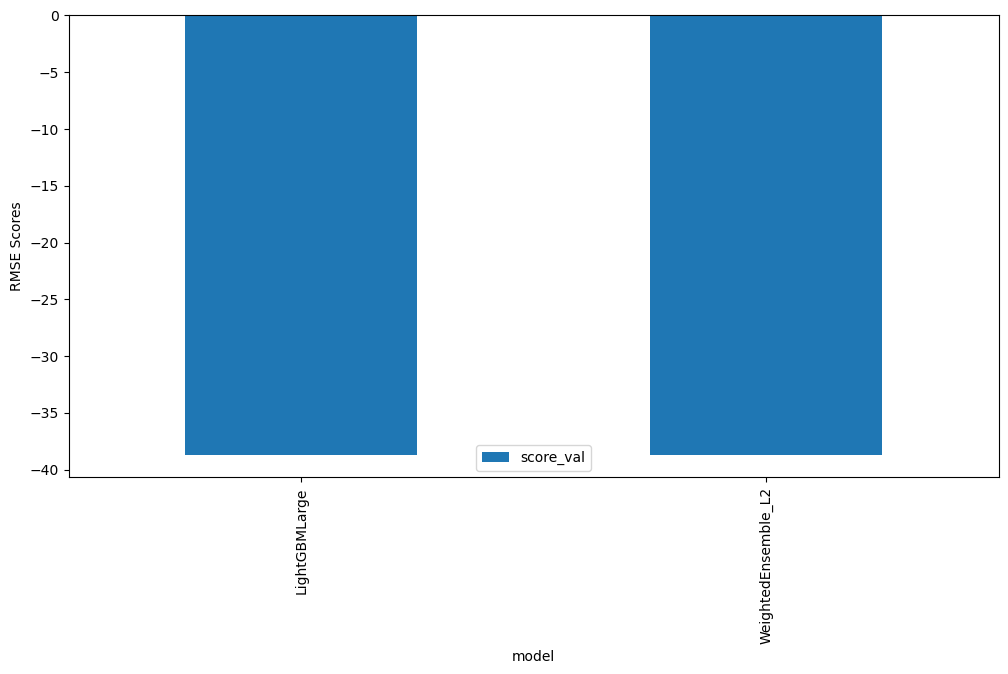

In [82]:
import matplotlib.pyplot as plt
leaderboard_new_hpo1_df.plot(kind="bar", x="model", y="score_val", figsize=(12, 6))
plt.ylabel("RMSE Scores")
plt.show()

## Step 7: Write a Report
### Refer to the markdown file for the full report
### Creating plots and table for report

          train      score
0       initial  52.800000
1  add_features  29.990000
2           hpo  30.680000
3          hpo1  38.747398
           test    score
0       initial  1.80000
1  add_features  0.68000
2           hpo  0.67000
3          hpo1  0.53574


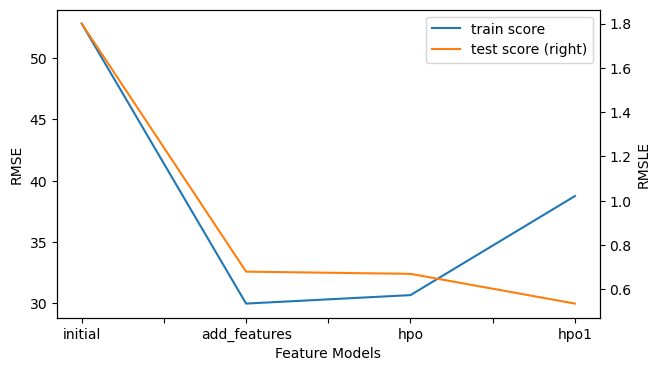

In [83]:
train_score_df = pd.DataFrame(
    {
    "train": ["initial", "add_features", "hpo", "hpo1"],
    "score": [52.80, 29.99, 30.68, 38.747398 ],
    })

test_score_df = pd.DataFrame(
    {
        "test": ["initial", "add_features", "hpo", "hpo1"],
        "score": [1.80, 0.68, 0.67, 0.53574]
    })
print(train_score_df)
print(test_score_df)

# Plot a figure with train and test scores
fig, ax = plt.subplots(1,1, figsize=(7, 4))
train_score_df.plot(x="train", y="score", ax=ax, label='train score')
test_score_df.plot(x="test", y="score", ax=ax, secondary_y=True, label='test score')

ax.set_xlabel('Feature Models')
ax.set_ylabel('RMSE')
ax.right_ax.set_ylabel('RMSLE')
fig.savefig('img/compare_train_test_score')



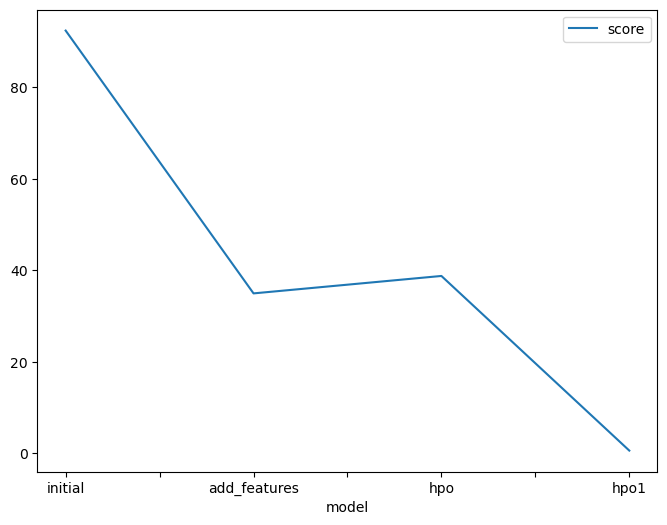

In [84]:
# Taking the top model score from each training run and creating a line plot to show improvement
# You can create these in the notebook and save them to PNG or use some other tool (e.g. google sheets, excel)
import pandas as pd
fig = pd.DataFrame(
    {
        "model": ["initial", "add_features", "hpo", "hpo1"],
        "score": [92.442085, 34.933550, 38.747398, 0.53574 ]
    }
).plot(x="model", y="score", figsize=(8, 6)).get_figure()
fig.savefig('img/model_train_score.png')

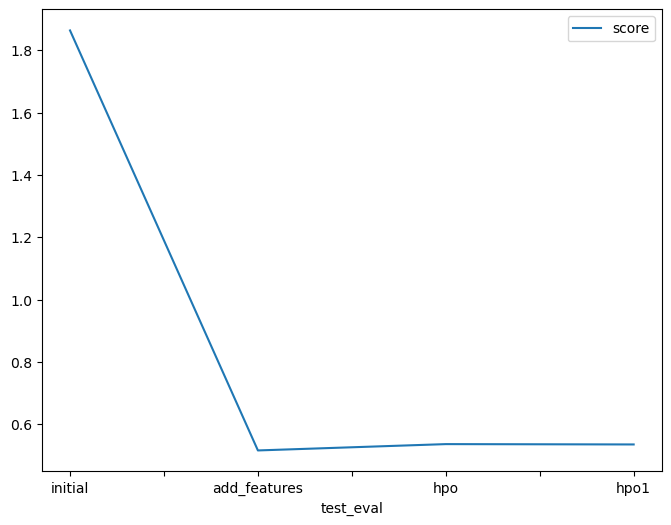

In [85]:
# Take the 3 kaggle scores and creating a line plot to show improvement
fig = pd.DataFrame(
    {
        "test_eval": ["initial", "add_features", "hpo", "hpo1"],
        "score": [1.86378, 0.51653, 0.53682, 0.53574 ]
    }
).plot(x="test_eval", y="score", figsize=(8, 6)).get_figure()
fig.savefig('img/model_test_score.png')

### Hyperparameter table

In [101]:
# The 3 hyperparameters we tuned with the kaggle score as the result

import pandas as pd

import dataframe_image as dfi
fig = pd.DataFrame({
    "model": ["initial", "add_features", "hpo", "hpo1"],
    "hpo1": [
        'default_vals', 
        'default_vals',
        'default_vals', 
        'default_vals'
        ],
    "hpo2": [
        'default_vals', 
        'default_vals',
        'default_vals', 
        'default_vals'],
    "hpo3": [
        'default_vals', 
        'default_vals',
        'default_vals', 
        'default_vals'],
    "score": [1.86378, 0.51653, 0.53682, 0.53574 ]
})
fig




,model,hpo1,hpo2,hpo3,score
0,initial,default_vals,default_vals,default_vals,1.86378
1,add_features,default_vals,default_vals,default_vals,0.51653
2,hpo,default_vals,default_vals,default_vals,0.53682
3,hpo1,default_vals,default_vals,default_vals,0.53574


Export to html
jupyter nbconvert --to html --execute project.ipynb --ExecutePreprocessor.kernel_name=python3

Upload to S3 bucket
aws s3 cp ./project.html S3://<bucket>/<prefix>